In [2]:
import random
import json
import re
import os
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer as wnl


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
random.seed(6)
np.random.seed(6)

WORK_DIR = Path.cwd().parent


In [3]:
import nltk
# Download required NLTK data
# Run if needed
# nltk.download('punkt_tab')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')


# Experiment ? - Llama3.2 3b on chat mode

In this experiment I feed the the model a revisioned version of the input, where the STSG is put the beginning of the prompt and the question with the alternatives at the end. Finally I ask the model to reason about the possible answer *step by step*, conditioning it to perform Zero-Shot-CoT (Prompt engineering technique where no example of thow to perform the reasoning is provided -- no in-context learning). Moreover, instead of asking the model to provide the answer on the same promtp, I instatied the model in multi-turn chat mode where, after the model gives the first response, a script sends an automatic reply asking to extract the final answer given by the model and give it a json format.

**Parameters:**
- model: Gemma3 12b
- system prompt: MCQ_system_promtp_ZS_CoT.txt
- user_prompt: MCQ_user_prompt_ZS_CoT_v2.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)


## Prompts

In [4]:
with open(WORK_DIR / 'data/prompts/zero-shot-cot/MCQ_system_prompt_ZS_CoT.txt', 'r') as f:
    pr = f.read()

print(pr)


You need to respond to reasoning questions by making logical inference on sequence of Scene-Graphs extracted from frames belonging to a video, called a Spatio-Temporal Scene Graph.

IMPORTANT CLARIFICATIONS:
- You will receive a question and Spatio-Temporal Scene-Graph
- Each Scene-Graph is a static symbolic representation of the scene unfolding in the frame
- The Scene-Graphs are ordered chronologically
- The Scene-Graph is represented as a set of tuple in the format: subject - relationship - object
- The Spatio-Temporal Scene-Graph is a cornologically sorted list of Scene-Graphs

INSTRUCTIONS:
- Read the entire Spatio-Temporal Scene-Graphs in chronological order and pay attention at the order of how events unfold.
- Read the question and reason about the answer step by step.
- In your answer include key events or relationships that help you in determing the correct answer.
- Be careful to reproduce the chosen alternative as it is presented.


In [5]:
with open(WORK_DIR / 'data/prompts/zero-shot-cot/MCQ_user_prompt_ZS_CoT_v2.txt', 'r') as f:
    pr = f.read()

print(pr)


Please carefully read the following Spatio-Temporal Scene Graph delimited by the <STSG> tags and provide an answer to the question below:

<STSG>
{stsg}
</STSG>

Given the following question:
<Q>
{question}
<Q>

And the following alternatives:
<Alternatives>
A. {c1}
B. {c2}
C. {c3}
D. {c4}
</Alternatives>

Provide an answer to the above question reasoning step by step on the Spatio-Temporal Scene-Graph (STSG) and choosing one of the alternatives.


In [6]:
reply = """\
Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.\
"""

print(reply)


Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [7]:
ground_truth = []

with open(WORK_DIR / 'data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'question': sample['question'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])],
        'stsg': sample['stsg'],
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,question,choices,num,text,stsg
id,,,,,
Interaction_T1_13,Which object was tidied up by the person?,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.,"[[person - on_the_side_of - clothes], [person ..."
Interaction_T1_14,Which object was tidied up by the person?,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.,"[[person - holding - towel, person - in_front_..."
Interaction_T1_31,Which object was thrown by the person?,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.,"[[person - wearing - clothes, person - above -..."
Interaction_T1_32,Which object was put down by the person?,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.,"[[person - on_the_side_of - clothes, person - ..."
Interaction_T1_40,Which object was tidied up by the person?,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.,"[[person - holding - clothes, person - in_fron..."
...,...,...,...,...,...
Feasibility_T6_1453,What is the person able to do after taking the...,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.,"[[person - on_the_side_of - table, person - ho..."
Feasibility_T6_1454,What is the person able to do after walking th...,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.,"[[person - in_front_of - table], [person - in_..."
Feasibility_T6_1455,What is the person able to do after walking th...,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.,"[[person - in_front_of - table], [person - in_..."


## Loading predicted answers evaluation

In [8]:
predictions = []
with open(WORK_DIR / 'outputs/responses_to_genframes_gemma3:4b_1604_p1.jsonl', mode='r', encoding='utf-8', errors='strict') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id'})
predictions_df.set_index('id', inplace=True)
predictions_df



,chat_history
id,
Interaction_T2_3150,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T1_5784,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T2_3935,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T1_5311,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T1_2219,"[{'role': 'user', 'content': 'Please carefully..."
...,...
Prediction_T3_183,"[{'role': 'user', 'content': 'Please carefully..."
Prediction_T1_1161,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T4_2027,"[{'role': 'user', 'content': 'Please carefully..."


In [9]:
predictions_df['chat_history'] = \
    predictions_df['chat_history'] \
    .apply(lambda x: eval(x))

predictions_df


,chat_history
id,
Interaction_T2_3150,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T1_5784,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T2_3935,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T1_5311,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T1_2219,"[{'role': 'user', 'content': 'Please carefully..."
...,...
Prediction_T3_183,"[{'role': 'user', 'content': 'Please carefully..."
Prediction_T1_1161,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T4_2027,"[{'role': 'user', 'content': 'Please carefully..."


In [10]:
predictions_df['answer'] = predictions_df['chat_history'].apply(lambda x: x[-1]['content'])


In [11]:
predictions_df['answer'].iloc[0:5] 


id
Interaction_T2_3150           ```json\n{"answer": "A. Lied on."}\n```
Sequence_T1_5784       ```json\n{"answer": "B. The sofa/couch."}\n```
Interaction_T2_3935          ```json\n{"answer": "B. Put down."}\n```
Sequence_T1_5311              ```json\n{"answer": "B. The box."}\n```
Sequence_T1_2219            ```json\n{"answer": "B. The floor."}\n```
Name: answer, dtype: object

## Text preprocessing

For Gemma we need to be more careful becuase the format is different, it encapsulated the json output in the with the tokens: 
```
```json\n
<actual_answer>
\n```
```

In [12]:

# Create mask for answers that follow JSON syntax
json_mask = predictions_df['answer'].str.match(r'^(```json\s)?({[^}]+})(\s```)?$')
matches_json_template = json_mask.sum()

print(f"Total answers: {len(predictions_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(predictions_df))*100:.2f}%")


Total answers: 774
Answers following JSON template: 774
Percentage following JSON template: 100.00%


In [13]:
predictions_df.loc[~json_mask, 'answer']


Series([], Name: answer, dtype: object)

In [14]:
predictions_df.loc[json_mask, 'answer'] = \
    predictions_df.loc[json_mask, 'answer'] \
    .apply(lambda x: re.search(r'^(?:```json\s)?({[^}]+})(?:\s```)?$', x).group(1))

predictions_df.loc[~json_mask, 'answer'] = ""
predictions_df['answer']


id
Interaction_T2_3150               {"answer": "A. Lied on."}
Sequence_T1_5784           {"answer": "B. The sofa/couch."}
Interaction_T2_3935              {"answer": "B. Put down."}
Sequence_T1_5311                  {"answer": "B. The box."}
Sequence_T1_2219                {"answer": "B. The floor."}
                                       ...                 
Prediction_T3_183                {"answer": "C. The table"}
Prediction_T1_1161        {"answer": "D. Open the laptop."}
Sequence_T4_2027       {"answer": "C. Washed the clothes."}
Interaction_T1_1301            {"answer": "A. The laptop."}
Sequence_T1_4963                 {"answer": "A. The dish."}
Name: answer, Length: 774, dtype: object

### The need to replace single quotes

In [15]:
print('\u2018'), print('\u2019'), print('\u201a'), print('\u201b'), print('\u201c'), print('\u201d')


‘
’
‚
‛
“
”


(None, None, None, None, None, None)

In [16]:
import unicodedata

def print_unicode_codes(s):
    print("Char | Unicode Point | UTF-8 Bytes | Name")
    print("-" * 50)
    for char in s:
        code = ord(char)
        utf8_bytes = list(char.encode('utf-8'))
        try:
            name = unicodedata.name(char)
        except ValueError:
            name = "No name"
        print(f"'{char}'  | U+{code:04X}       | {utf8_bytes}      | {name}")

# Requires: import unicodedata
# print_unicode_codes(el['answer'])


In [17]:
import tokenize
from io import StringIO
import ast

def debug_parsing(code):
    try:
        # First try full parse
        ast.parse(code)
    except SyntaxError as e:
        print(f"Full parse failed at line {e.lineno}")
        print("Token stream up to error:")
        
        # Show token stream
        tokens = tokenize.generate_tokens(StringIO(code).readline)
        for tok in tokens:
            print(f"{tokenize.tok_name[tok.type]:<15} {tok.string!r:<20} {tok.start}->{tok.end}")
            if tok.start[0] > e.lineno or (
                tok.start[0] == e.lineno and tok.start[1] >= e.offset
            ):
                print("-- Error occurs here --")
                break

#debug_parsing(el['answer'])


### Applying changes

In [18]:
# Replace new line (lead to EOF Errors) with whitespace
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('\n+', ' ', regex=True)

# Replace lef and right quotation mark with simple quotation mark
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u2018-\u201b]', '\'', regex=True)
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u201c\u201d]', '"', regex=True)
# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason paramter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"(?<=\"answer\": \")(.*)(?=\"(?:,|}))"

predictions_df['answer'] = \
    predictions_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(0).replace('\"', ''), 
            row['answer']),
        axis=1
        )


In [19]:
predictions_df.loc[json_mask, 'answer'] = predictions_df.loc[json_mask, 'answer'].apply(lambda x: eval(x)['answer'].strip())
predictions_df


,chat_history,answer
id,,
Interaction_T2_3150,"[{'role': 'user', 'content': 'Please carefully...",A. Lied on.
Sequence_T1_5784,"[{'role': 'user', 'content': 'Please carefully...",B. The sofa/couch.
Interaction_T2_3935,"[{'role': 'user', 'content': 'Please carefully...",B. Put down.
Sequence_T1_5311,"[{'role': 'user', 'content': 'Please carefully...",B. The box.
Sequence_T1_2219,"[{'role': 'user', 'content': 'Please carefully...",B. The floor.
...,...,...
Prediction_T3_183,"[{'role': 'user', 'content': 'Please carefully...",C. The table
Prediction_T1_1161,"[{'role': 'user', 'content': 'Please carefully...",D. Open the laptop.
Sequence_T4_2027,"[{'role': 'user', 'content': 'Please carefully...",C. Washed the clothes.


In [20]:
ans_regex_pattern = r'^(?:[A-Z]\.)\s+((?:\w+(?:\s|\/)?){,10}\.?)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)

print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.shape[0]:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do NOT contain the answer in the response with the specified format")


Answer following the template: 663
85.66% of the total

Only 111 samples do NOT contain the answer in the response with the specified format


/tmp/ipykernel_2814/1875602683.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)


In [21]:
predictions_df.loc[~contains_answer, 'answer']


id
Sequence_T4_4838       None of the alternatives are correct based on ...
Sequence_T5_3075       None of the alternatives are correct because t...
Interaction_T1_3210    None of the alternatives are present in the Sp...
Prediction_T4_1252                 None of the alternatives are correct.
Sequence_T3_5072       None of the alternatives can be determined fro...
                                             ...                        
Sequence_T4_2127       None of the alternatives provided accurately d...
Sequence_T1_4745       None of the alternatives are present in the sc...
Sequence_T5_4393       None of the alternatives are correct because t...
Feasibility_T6_520     None of the alternatives are supported by the ...
Sequence_T5_554                    None of the alternatives are correct.
Name: answer, Length: 111, dtype: object

## Extract answers

In [22]:
ans_df = \
    predictions_df[contains_answer]['answer'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1]) \
    .apply(lambda x: x + '.' if not x.endswith('.') else x) \
    .to_frame(name='text')

ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df


,text
id,
Interaction_T2_3150,Lied on.
Sequence_T1_5784,The sofa/couch.
Interaction_T2_3935,Put down.
Sequence_T1_5311,The box.
Sequence_T1_2219,The floor.
...,...
Prediction_T3_183,The table.
Prediction_T1_1161,Open the laptop.
Sequence_T4_2027,Washed the clothes.


In [23]:
ans_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 663 entries, Interaction_T2_3150 to Sequence_T1_4963
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    663 non-null    object
dtypes: object(1)
memory usage: 10.4+ KB


In [24]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 276 unique answers


In [25]:
ans_df['text'].value_counts()


Put down.                 42
Took.                     34
The box.                  30
The bag.                  22
The cup/glass/bottle.     21
                          ..
Put down the laptop.       1
the bag.                   1
Open the refrigerator.     1
the phone/camera.          1
Washed the clothes.        1
Name: text, Length: 138, dtype: int64

<AxesSubplot: xlabel='freq', ylabel='word'>

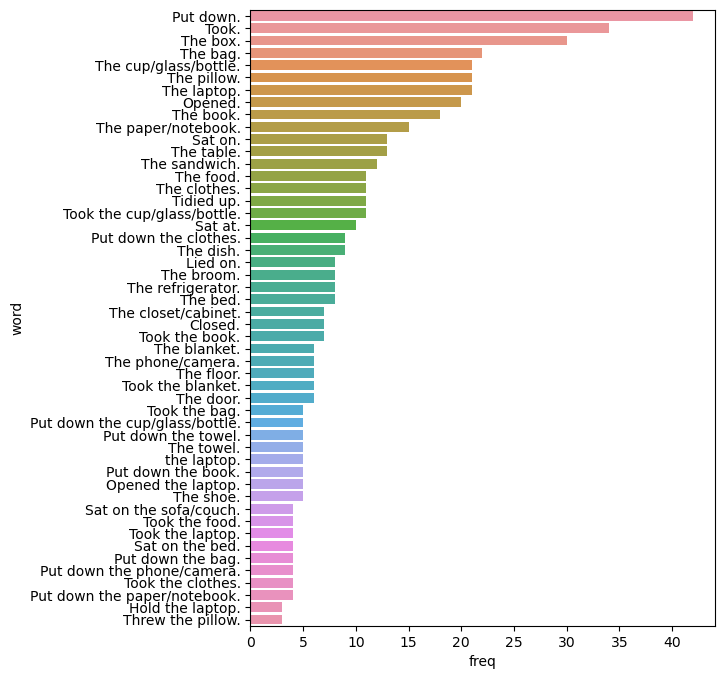

In [26]:
plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


Let's do some visualization also for the ground truth data

In [27]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


<AxesSubplot: xlabel='freq', ylabel='word'>

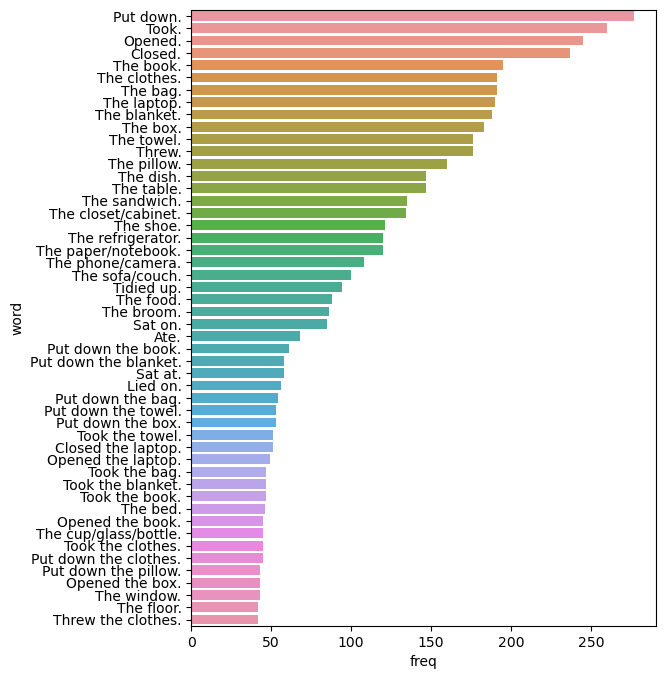

In [28]:
freq = gt_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


In [29]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(663, 6)

In [30]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'].str.lower() == eval_df[on_what].str.lower()).sum()
    

    return hits_text/eval_df.shape[0]


In [31]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [32]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction          208        38.94%  
Sequence             339        43.95%  
Prediction           66         34.85%  
Feasibility          50         32.00%  


In [33]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 3.79%


In [34]:
# % of answers conforming to template per category

def print_ans_perc(eval_df, gt_df):
    print(f"{'Question type':<15}{'Total':^15}{'Answered':^10}\n")

    total = gt_df.index.str.startswith('Interaction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Interaction')].index))/total
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Sequence').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Sequence')].index))/total
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Prediction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Prediction')].index))/total
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Feasibility').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Feasibility')].index))/total
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.shape[0]
    acc = eval_df.shape[0]/total
    print(f"{'Overall':<15}{total:^15}{acc:^10.2%}")

print_ans_perc(eval_df, gt_df)


Question type       Total      Answered 

Interaction         2398        8.67%   
Sequence            3586        9.45%   
Prediction           624        10.58%  
Feasibility          490        10.20%  
Overall             7098        9.34%   


## Graph analysis

In [35]:
gen_graphs = []
with open(WORK_DIR / "data/datasets/STAR_QA_and_gen_stsg_p1.json", "r") as in_f:
    gen_graphs = json.load(in_f)

gen_graphs = {d['question_id']: d['stsg'] for d in gen_graphs}
gen_graphs_se = pd.Series(gen_graphs)
gen_graphs_se


Interaction_T2_3150    \nFrame 000019:\n\nwoman ---- lying_on ---- be...
Sequence_T1_5784       \nFrame 000223:\n\nwoman ---- sitting_on ---- ...
Interaction_T2_3935    \nFrame 000012:\n\nwoman ---- holding ---- car...
Sequence_T1_5311       \nFrame 000099:\n\nman ---- standing_in_front_...
Sequence_T1_2219       \nFrame 000011:\n\nwoman ---- sitting_on ---- ...
                                             ...                        
Prediction_T3_183      \nFrame 000376:\n\nman ---- holding ---- jar\n...
Prediction_T1_1161     \nFrame 000328:\n\nwoman ---- sitting_on ---- ...
Sequence_T4_2027       \nFrame 000757:\n\nwoman ---- holding_object -...
Interaction_T1_1301    \nFrame 000546:\n\nwall ---- supports ---- flo...
Sequence_T1_4963       \nFrame 000090:\n\nFrame 000147:\n\nFrame 0001...
Length: 774, dtype: object

In [36]:
print(gen_graphs_se.iloc[33])



Frame 000551:

Frame 000599:

man ---- standing_in_front_of ---- shelf
shelf ---- mounted_on ---- wall
wall ---- white_color
shelf ---- holding ---- object1
object1 ---- type_of ---- box
object1 ---- on ---- shelf
man ---- looking_at ---- object1
object1 ---- on ---- shelf
man ---- adjacent_to ---- chair
chair ---- type_of ---- wooden_chair
chair ---- located_next_to ---- man
shelf ---- supporting ---- object1
wall ---- background_for ---- scene
man ---- adjacent_to ---- chair
chair ---- located_to_right_of ---- man
shelf ---- holding ---- object2
object2 ---- type_of ---- box
object2 ---- on ---- shelf
man ---- looking_at ---- object2
object2 ---- on ---- shelf
wall ---- background_for ---- scene

Frame 000657:

refrigerator ---- standing_in_front_of ---- man
man ---- looking_at ---- refrigerator
refrigerator ---- containing ---- drinks
drinks ---- consisting_of ---- red_bull_cans
drinks ---- containing ---- water_bottles
drinks ---- containing ---- beer_bottles
drinks ---- containin

In [37]:
def structure_stsg(g):
    sgs = g.split("Frame")

    sg_dict = {}
    for sg in sgs:
        sg = sg.strip()
        if sg != "":
            frame_id, val = [s.strip() for s in sg.split(":")]
            if val != "":
                sg_dict[frame_id] = val

    new = {}
    for k, sg in sg_dict.items():
        string_triplets = [s.strip() for s in sg.split("\n")]
        triplets = []
        for triplet in string_triplets:
            triplets.append([s.strip() for s in re.split("-+", triplet)])
        new[k] = triplets

    return new
    
struct_gen_graphs = gen_graphs_se.apply(structure_stsg)


In [38]:
struct_gen_graphs.iloc[33]


{'000599': [['man', 'standing_in_front_of', 'shelf'],
  ['shelf', 'mounted_on', 'wall'],
  ['wall', 'white_color'],
  ['shelf', 'holding', 'object1'],
  ['object1', 'type_of', 'box'],
  ['object1', 'on', 'shelf'],
  ['man', 'looking_at', 'object1'],
  ['object1', 'on', 'shelf'],
  ['man', 'adjacent_to', 'chair'],
  ['chair', 'type_of', 'wooden_chair'],
  ['chair', 'located_next_to', 'man'],
  ['shelf', 'supporting', 'object1'],
  ['wall', 'background_for', 'scene'],
  ['man', 'adjacent_to', 'chair'],
  ['chair', 'located_to_right_of', 'man'],
  ['shelf', 'holding', 'object2'],
  ['object2', 'type_of', 'box'],
  ['object2', 'on', 'shelf'],
  ['man', 'looking_at', 'object2'],
  ['object2', 'on', 'shelf'],
  ['wall', 'background_for', 'scene']],
 '000657': [['refrigerator', 'standing_in_front_of', 'man'],
  ['man', 'looking_at', 'refrigerator'],
  ['refrigerator', 'containing', 'drinks'],
  ['drinks', 'consisting_of', 'red_bull_cans'],
  ['drinks', 'containing', 'water_bottles'],
  ['drin

In [39]:
struct_gen_graphs['Interaction_T2_3150']


{'000019': [['woman', 'lying_on', 'bed'],
  ['bed', 'containing', 'sheets'],
  ['sheets', 'covering', 'mattress'],
  ['bed', 'adjacent_to', 'bedside_table'],
  ['bedside_table', 'supporting', 'lamp'],
  ['lamp', 'having_shade', 'lampshade'],
  ['lampshade', 'above', 'book'],
  ['book', 'on_top_of', 'bedside_table'],
  ['bed', 'adjacent_to', 'wall'],
  ['wall', 'supporting', 'curtains'],
  ['curtains', 'hanging_on', 'wall'],
  ['bed', 'on_top_of', 'floor'],
  ['floor', 'dark_color'],
  ['bed', 'adjacent_to', 'woman'],
  ['woman', 'lying_on', 'bed']],
 '000054': [['woman', 'lying_on', 'bed'],
  ['bed', 'containing', 'woman'],
  ['bed', 'supporting', 'pillow'],
  ['pillow', 'under', 'woman'],
  ['bed', 'adjacent_to', 'nightstand'],
  ['nightstand', 'holding', 'lamp'],
  ['lamp', 'emitting_light_on', 'nightstand'],
  ['nightstand', 'holding', 'books'],
  ['books', 'stacked_on', 'nightstand'],
  ['bed', 'against', 'wall'],
  ['wall', 'supporting', 'bed'],
  ['bed', 'adjacent_to', 'bookcase'

In [40]:
STAR_data = []
with open(WORK_DIR / "data/datasets/STAR/STAR_annotations/STAR_val.json") as in_f:
    STAR_data_df = pd.read_json(in_f)

STAR_data_df.set_index('question_id', inplace=True)
STAR_data_df.iloc[0]


question                    Which object was tidied up by the person?
video_id                                                        6H78U
start                                                            11.1
end                                                              19.6
answer                                                   The clothes.
question_program    [{'function': 'Situations', 'value_input': []}...
choices             [{'choice_id': 0, 'choice': 'The closet/cabine...
situations          {'000206': {'rel_pairs': [['o000', 'o027'], ['...
Name: Interaction_T1_13, dtype: object

Some situations instances in the dataset contain frames with no Scene-Graph annotation, or better, they annotate only the high level action occuring in the frame. An example is the instance `Feasibility_T3_86`.

In [41]:
STAR_data_df.loc['Feasibility_T3_86']['situations']['000047']


{'rel_pairs': [],
 'rel_labels': [],
 'actions': ['a102'],
 'bbox': [],
 'bbox_labels': []}

In [42]:
def get_vocab_map(label_dir):
    vocab_map = dict()

    with open(label_dir) as in_file:
        for line in in_file.readlines():
            mapping = line.strip('\n')
            key, val = mapping.split(' ')
            vocab_map[key] = val
    
    return vocab_map

def textual_stsg(q_data):
    frame_ids = sorted(q_data['situations'].keys())

    stsg = {}
    for f in frame_ids:
        frame_sg = []
        rels = q_data['situations'][f]['rel_labels']
        
        if rels == []:
            # There are some frames in the ground truth without any scene graph
            # annotation
            continue
        for rel_pair, rel in zip(q_data['situations'][f]['rel_pairs'], rels):
            obj1, obj2 = rel_pair
            frame_sg.append([obj_vocab[obj1], rel_vocab[rel], obj_vocab[obj2]])

        stsg[f] = frame_sg
    
    return stsg


obj_vocab = get_vocab_map(WORK_DIR / 'data/datasets/STAR/STAR_annotations/class_maps/object_classes.txt')
rel_vocab = get_vocab_map(WORK_DIR /  'data/datasets/STAR/STAR_annotations/class_maps/relationship_classes.txt')


In [43]:
textual_stsg(STAR_data_df.iloc[0])


{'000198': [['person', 'on_the_side_of', 'clothes']],
 '000202': [['person', 'in_front_of', 'clothes']],
 '000205': [['person', 'in_front_of', 'clothes'],
  ['person', 'in_front_of', 'blanket']],
 '000206': [['person', 'in_front_of', 'towel'],
  ['person', 'in_front_of', 'clothes'],
  ['person', 'in_front_of', 'blanket'],
  ['person', 'on_the_side_of', 'blanket']],
 '000212': [['person', 'on_the_side_of', 'towel'],
  ['person', 'in_front_of', 'towel'],
  ['person', 'in_front_of', 'clothes'],
  ['person', 'on_the_side_of', 'blanket']],
 '000217': [['person', 'in_front_of', 'towel'],
  ['person', 'on_the_side_of', 'clothes'],
  ['person', 'in_front_of', 'blanket'],
  ['person', 'on_the_side_of', 'blanket']],
 '000218': [['person', 'in_front_of', 'clothes'],
  ['person', 'in_front_of', 'blanket'],
  ['person', 'on_the_side_of', 'blanket']],
 '000221': [['person', 'in_front_of', 'towel'],
  ['person', 'in_front_of', 'clothes'],
  ['person', 'in_front_of', 'blanket']],
 '000223': [['person'

In [44]:
STAR_data_df['stsg'] = STAR_data_df.apply(func=textual_stsg, axis=1)
STAR_data_df.iloc[1]['stsg']


{'000286': [['person', 'holding', 'towel'],
  ['person', 'in_front_of', 'towel'],
  ['person', 'holding', 'clothes'],
  ['person', 'in_front_of', 'clothes'],
  ['person', 'holding', 'blanket'],
  ['person', 'in_front_of', 'blanket']],
 '000289': [['person', 'holding', 'towel'],
  ['person', 'in_front_of', 'towel'],
  ['person', 'holding', 'clothes'],
  ['person', 'in_front_of', 'clothes'],
  ['person', 'in_front_of', 'blanket'],
  ['person', 'on_the_side_of', 'blanket']],
 '000294': [['person', 'holding', 'towel'],
  ['person', 'in_front_of', 'towel'],
  ['person', 'holding', 'clothes'],
  ['person', 'in_front_of', 'clothes'],
  ['person', 'in_front_of', 'blanket']],
 '000301': [['person', 'holding', 'clothes'],
  ['person', 'in_front_of', 'clothes']],
 '000303': [['person', 'in_front_of', 'towel'],
  ['person', 'holding', 'clothes'],
  ['person', 'in_front_of', 'clothes'],
  ['person', 'holding', 'blanket'],
  ['person', 'in_front_of', 'blanket']],
 '000308': [['person', 'in_front_of'

In [45]:
test_id = struct_gen_graphs.index[0]
test_id


'Interaction_T2_3150'

In [46]:
struct_gen_graphs[test_id]


{'000019': [['woman', 'lying_on', 'bed'],
  ['bed', 'containing', 'sheets'],
  ['sheets', 'covering', 'mattress'],
  ['bed', 'adjacent_to', 'bedside_table'],
  ['bedside_table', 'supporting', 'lamp'],
  ['lamp', 'having_shade', 'lampshade'],
  ['lampshade', 'above', 'book'],
  ['book', 'on_top_of', 'bedside_table'],
  ['bed', 'adjacent_to', 'wall'],
  ['wall', 'supporting', 'curtains'],
  ['curtains', 'hanging_on', 'wall'],
  ['bed', 'on_top_of', 'floor'],
  ['floor', 'dark_color'],
  ['bed', 'adjacent_to', 'woman'],
  ['woman', 'lying_on', 'bed']],
 '000054': [['woman', 'lying_on', 'bed'],
  ['bed', 'containing', 'woman'],
  ['bed', 'supporting', 'pillow'],
  ['pillow', 'under', 'woman'],
  ['bed', 'adjacent_to', 'nightstand'],
  ['nightstand', 'holding', 'lamp'],
  ['lamp', 'emitting_light_on', 'nightstand'],
  ['nightstand', 'holding', 'books'],
  ['books', 'stacked_on', 'nightstand'],
  ['bed', 'against', 'wall'],
  ['wall', 'supporting', 'bed'],
  ['bed', 'adjacent_to', 'bookcase'

In [47]:
STAR_data_df.loc[test_id]['stsg']


{'000019': [['person', 'lying_on', 'bed'],
  ['person', 'above', 'bed'],
  ['person', 'behind', 'bed']],
 '000027': [['person', 'lying_on', 'bed'],
  ['person', 'above', 'bed'],
  ['person', 'behind', 'bed']],
 '000054': [['person', 'lying_on', 'bed'],
  ['person', 'on_the_side_of', 'bed'],
  ['person', 'above', 'bed']],
 '000079': [['person', 'sitting_on', 'bed'],
  ['person', 'on_the_side_of', 'bed'],
  ['person', 'above', 'bed']],
 '000089': [['person', 'sitting_on', 'bed'],
  ['person', 'touching', 'bed'],
  ['person', 'beneath', 'bed'],
  ['person', 'on_the_side_of', 'bed']],
 '000124': [['person', 'sitting_on', 'bed'],
  ['person', 'beneath', 'bed'],
  ['person', 'on_the_side_of', 'bed']],
 '000127': [['person', 'sitting_on', 'bed'],
  ['person', 'beneath', 'bed'],
  ['person', 'on_the_side_of', 'bed']],
 '000131': [['person', 'sitting_on', 'bed'],
  ['person', 'beneath', 'bed'],
  ['person', 'on_the_side_of', 'bed']],
 '000159': [['person', 'sitting_on', 'bed'],
  ['person', 'be

In [48]:
# check that the generated frema
all([key in list(STAR_data_df.loc[test_id]['stsg'].keys()) for key in struct_gen_graphs[test_id].keys()])


True

In [49]:
def recall_at_k(gt, pred, k=10):
    o1 = set([sg[0] for sg in gt])
    rel = set([sg[1] for sg in gt])
    o2 = set([sg[2] for sg in gt])
    
    o1_pred = set([sg[0] for sg in pred])
    rel_pred = set([sg[1] for sg in pred])
    o2_pred = set([sg[2] for sg in pred if len(sg) > 2])
    
    o1_recall = len(o1.intersection(o1_pred))/len(o1)
    rel_recall = len(rel.intersection(rel_pred))/len(rel)
    o2_recall = len(o2.intersection(o2_pred))/len(o2)
    
    # TODO: missing a reflexivity relation where o1 - rel1 - o2 might be equivaletn to o2 - rel2 - o1
    
    return o1_recall, rel_recall, o2_recall

def average_recall(situation_id, gt_dict, pred_dict, k=10):
    
    mean_o1 = 0
    mean_rel = 0
    mean_o2 = 0
    for i, frame_id in enumerate(pred_dict[situation_id]):
        # Previously we filterd some frames in the gt beacuse
        # there were no SG annotation, which yieled division by
        # zero because o1, rel, o2 are empty
        if frame_id not in pred_dict[situation_id] \
            or frame_id not in  gt_dict[situation_id]:
            continue
        pred_sg = pred_dict[situation_id][frame_id]
        gt_sg = gt_dict[situation_id][frame_id]
        o1_recall, rel_recall, o2_recall = recall_at_k(gt_sg, pred_sg, k)
        
        mean_o1 = (i * mean_o1 + o1_recall) / (i + 1)
        mean_rel = (i * mean_rel + rel_recall) / (i + 1)
        mean_o2 = (i * mean_o2 + o2_recall) / (i + 1)
        
    return mean_o1, mean_rel, mean_o2
    
o1_recall, rel_recall, o2_recall = average_recall(test_id, STAR_data_df['stsg'], struct_gen_graphs)

print(f"Eval for id {test_id}")
print(f"{'- Recall (o1)':<15}: {o1_recall:.3f}")
print(f"{'- Recall (rel)':<15}: {rel_recall:.3f}")
print(f"{'- Recall (o2)':<15}: {o2_recall:.3f}")
print()


Eval for id Interaction_T2_3150
- Recall (o1)  : 0.000
- Recall (rel) : 0.375
- Recall (o2)  : 1.000



In [50]:
test_id = struct_gen_graphs.index[10]

o1_recall, rel_recall, o2_recall = average_recall(test_id, STAR_data_df['stsg'], struct_gen_graphs)

print(f"Eval for id {test_id}")
print(f"{'- Recall (o1)':<15}: {o1_recall:.3f}")
print(f"{'- Recall (rel)':<15}: {rel_recall:.3f}")
print(f"{'- Recall (o2)':<15}: {o2_recall:.3f}")


Eval for id Sequence_T1_5008
- Recall (o1)  : 0.000
- Recall (rel) : 0.556
- Recall (o2)  : 0.315


Compute the average recall (at the average recall situation wise) for the whole dataset:

In [51]:

mean_o1 = 0
mean_rel = 0
mean_o2 = 0
o2s = []
for i, situation_id in enumerate(struct_gen_graphs.index):
    o1_recall, rel_recall, o2_recall = average_recall(situation_id, STAR_data_df['stsg'], struct_gen_graphs)
    
    o2s.append(o2_recall)
    mean_o1 = (i * mean_o1 + o1_recall) / (i + 1)
    mean_rel = (i * mean_rel + rel_recall) / (i + 1)
    mean_o2 = (i * mean_o2 + o2_recall) / (i + 1)

print(f"{'- Recall (o1)':<15}: {mean_o1:.3f}")
print(f"{'- Recall (rel)':<15}: {mean_rel:.3f}")
print(f"{'- Recall (o2)':<15}: {mean_o2:.3f}")


- Recall (o1)  : 0.064
- Recall (rel) : 0.254
- Recall (o2)  : 0.189


In [52]:
from graphviz import Digraph
from IPython.display import Image

def draw_graph(graph_data, output_file="graph.gv"):
    g = Digraph('G', filename=output_file)
    
    g.attr(
        rankdir='LR', #left to right layout
        splines='curved', # shape of edges
        overlap='false', # how to handle nodes overlap
        nodesep='0.5',
        ranksep='1.0'
    )

    for item in graph_data:
        if len(item) > 1:
            o1, rel = item[0], item[1]
            g.node(o1, shape='ellipse', color='lightblue')
            g.node(rel, shape='box', color='pink')
            g.edge(o1, rel)
            
            if len(item) > 2:
                o2 = item[2]
                g.node(o2, shape='ellipse', color='lightblue')
                g.edge(rel, o2)
                
    return g

def draw_graph_2(graph_data, output_file="graph.gv"):
    g = Digraph('G', filename=output_file)
    
    g.attr(
        rankdir='LR', #left to right layout
        splines='line', # shape of edges
        overlap='false', # how to handle nodes overlap
        nodesep='0.5',
        ranksep='1.0'
    )

    for item in graph_data:
        if len(item) > 1:
            o1, rel = item[0], item[1]
            g.node(o1, shape='ellipse', color='lightblue')
        
            if len(item) > 2:
                o2 = item[2]
                g.node(o2, shape='ellipse', color='lightblue')
                g.edge(o1, o2, label=rel)
            else:
                g.edge(o1, o1, label=rel)
                
    return g


def draw_tripartite_graph(graph_data, output_file="graph.gv"):
    """
    Draws a proper tripartite graph with three distinct layers:
    Left (objects) - Middle (relations) - Right (objects)
    
    Args:
        graph_data: List of relationships as [['o1', 'rel', 'o2'],...] or [['o1', 'rel'],...]
        output_file: Output file path (default: "graph.gv")
    Returns:
        The graphviz Digraph object
    """
    g = Digraph('G', filename=output_file)
    
    # Graph styling
    g.attr(rankdir='LR', splines='line', overlap='false', 
           nodesep='0.5', ranksep='1.0')
    
    # Track nodes and their positions
    left_nodes = {}
    middle_nodes = {}
    right_nodes = {}
    edges = set()
    
    # Process all relationships
    for item in graph_data:
        if len(item) >= 2:
            src, rel = item[0], item[1]
            
            # key -> label
            left_nodes[f"l_{src}"] = src
            
            if len(item) >= 3:
                dest = item[2]
                right_nodes[f"r_{dest}"] = dest

                # keeping the dest as id for disambiguation
                middle_nodes[f"m_{rel}_{dest}"] = rel
                edges.add((f"l_{src}", f"m_{rel}_{dest}"))
                edges.add((f"m_{rel}_{dest}", f"r_{dest}"))
            else:
                middle_nodes[f"m_{rel}"] = rel
                edges.add((f"l_{src}", f"m_{rel}"))
                

    for node, label in left_nodes.items():
        g.node(node, label, shape='ellipse', color='lightblue')
    
    for node, label in right_nodes.items():
        g.node(node, label, shape='ellipse', color='lightblue')
        
    for node, label in middle_nodes.items():
        g.node(node, label, shape='box', color='pink')
        
    for src, dest in edges:
        g.edge(src, dest)
    # Enforce tripartite structure using rank groups
    # a subgraph can be used to represent graph structure, 
    # indicating that certain nodes and edges should be 
    # grouped together
    with g.subgraph() as left:
        left.attr(rank='same')
        for node in left_nodes:
            left.node(node)
    
    with g.subgraph() as middle:
        middle.attr(rank='same')
        for node in middle_nodes:
            middle.node(node)
    
    with g.subgraph() as right:
        right.attr(rank='same')
        for node in right_nodes:
            right.node(node)
    
    # Render and display
    g.render(format='png', cleanup=True)
    # display(Image(filename=f"{output_file}.png"))
    return g


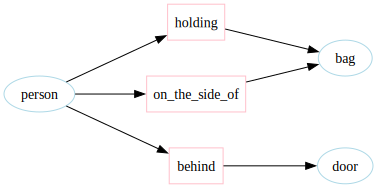

In [53]:
draw_tripartite_graph(STAR_data_df.loc[test_id]['stsg']['000019'])


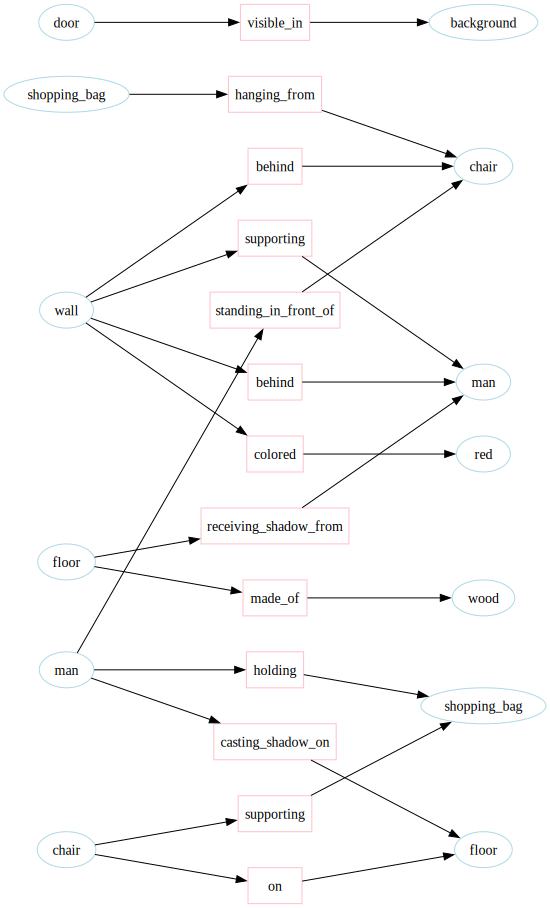

In [54]:
draw_tripartite_graph(struct_gen_graphs[test_id]['000019'])


In [55]:
r_o1, r_rel, r_o2 = recall_at_k(STAR_data_df.loc[test_id]['stsg']['000019'], struct_gen_graphs[test_id]['000019'])

print(f"Eval for id {test_id}")
print(f"{'- Recall (o1)':<15}: {r_o1:.3f}")
print(f"{'- Recall (rel)':<15}: {r_rel:.3f}")
print(f"{'- Recall (o2)':<15}: {r_o2:.3f}")


Eval for id Sequence_T1_5008
- Recall (o1)  : 0.000
- Recall (rel) : 0.667
- Recall (o2)  : 0.000


Clearly the above recall values are not representative of the actual similarity between the two graphs. 
It's evident that the character by character exact matching we are using is not informative enough. The generated graph contains the predicate `man - holding - shopping_bag`, therfore we get recall values for the left-handside (o1) and right-handside object (o2) of 0 beacuse the ground-truth predicate catually is `person - holding - bag`. The escat mathcing approach is not able to capture the fact that `man` and `person`, and `shopping_bag` and `bag`, (in this context) represent the same concept and should be considered the same.


TODO
Moreover the recall value for relationships is over optimistics because it capture both `holding` and `behind` but the latter one is not part in the correct predicate for the ground-truth. The problem can be solved by computing the recall value at the predicate level, but only after fixing the low values due to the exact matching approach, which overlooks the semantic similarity between words.


### Wordent
Let's use `wordent` an try to aggregate words with simialry meaning.


> WordNet® is a large lexical database of English. Nouns, verbs, adjectives and adverbs are grouped into sets of cognitive synonyms (synsets), each expressing a distinct concept. Synsets are interlinked by means of conceptual-semantic and lexical relations. 
> 
> WordNet superficially resembles a thesaurus, in that it groups words together based on their meanings. However, there are some important distinctions. 
> - First, WordNet interlinks not just word forms—strings of letters—but specific senses of words. As a result, words that are found in close proximity to one another in the network are semantically disambiguated. 
> - Second, WordNet labels the semantic relations among words, whereas the groupings of words in a thesaurus does not follow any explicit pattern other than meaning similarity.

In [56]:
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer as wnl


In [57]:
# get the different synsets (concept) that can be associated to
# the word in the specified part-of-speech (pos)
# 
# Synset: a set of synonyms that share a common meaning.
wn.synsets('man', pos=wn.NOUN)


[Synset('man.n.01'),
 Synset('serviceman.n.01'),
 Synset('man.n.03'),
 Synset('homo.n.02'),
 Synset('man.n.05'),
 Synset('man.n.06'),
 Synset('valet.n.01'),
 Synset('man.n.08'),
 Synset('man.n.09'),
 Synset('man.n.10'),
 Synset('world.n.08')]

In [58]:
print('man.n.01\n - ', wn.synset('man.n.01').definition(), '\n')
print('man.n.02\n - ', wn.synset('man.n.02').definition(), '\n')
print('man.n.03\n - ', wn.synset('man.n.03').definition(), '\n')


man.n.01
 -  an adult person who is male (as opposed to a woman) 

man.n.02
 -  someone who serves in the armed forces; a member of a military force 

man.n.03
 -  the generic use of the word to refer to any human being 



In [59]:
wn.synset('man.n.02').definition()


'someone who serves in the armed forces; a member of a military force'

In [60]:
man = wn.synset('man.n.01')
for i in man.closure(lambda s: s.hypernyms(), depth=1):
    print(i)


Synset('adult.n.01')
Synset('male.n.02')


In [61]:
wn.synonyms('man')


[['adult_male'],
 ['military_man', 'military_personnel', 'serviceman'],
 [],
 ['homo', 'human', 'human_being'],
 [],
 [],
 ['gentleman', "gentleman's_gentleman", 'valet', 'valet_de_chambre'],
 [],
 ['Isle_of_Man', 'Man'],
 ['piece'],
 ['human_beings',
  'human_race',
  'humanity',
  'humankind',
  'humans',
  'mankind',
  'world'],
 [],
 []]

In [62]:
# similarity metrics based on the path distances in the hypernym/hyponym taxonomy.

def path_similarity(word1, word2, pos=None):
    # path similarity
    #
    # sim = 1 / (p + 1)
    # where p is the length of the shortest path between two sysnsets
    
    synsets1 = wn.synsets(word1, pos)
    synsets2 = wn.synsets(word2, pos)
    
    if not synsets1 or not synsets2:
        return 0.0
    
    max_similarity = 0.0
    for syn1 in synsets1:
        for syn2 in synsets2:
            s = syn1.path_similarity(syn2)
            if s is not None and s > max_similarity:  # Check for None
                max_similarity = s
                
    return max_similarity

def lch_similarity(word1, word2, pos=None):
    #   
    #
    # sim = -log( (p + 1) / 2d )
    # where:
    # - p is the length of the shortest path between two sysnset
    # - d is the maximum taxonomy depth
    
    synsets1 = wn.synsets(word1, pos)
    synsets2 = wn.synsets(word2, pos)
    
    # no synsets found
    if not synsets1 or not synsets2:
        return 0.0
    
    max_similarity = 0.0
    for syn1 in synsets1:
        for syn2 in synsets2:
            if syn1.pos() == syn2.pos():  # Same part of speech (noun, verb, etc.)
                s = syn1.lch_similarity(syn2)
                if s > max_similarity:
                    max_similarity = s
                
    return max_similarity

def wup_similarity(word1, word2, pos=None):
    # Wu-Palmer Similarity
    #
    # sim = 2k / (i + j + 2k)
    #
    # where defined lCS as the lowest common hypernym:
    # - i is the shortest path distance from the first synset to LCS
    # - j is the shortest path distance from the second synset to LCS
    # - k  is the number of nodes (distance + 1) from LCS to the root node
    
    synsets1 = wn.synsets(word1, pos)
    synsets2 = wn.synsets(word2, pos)
    
    # no synsets found
    if not synsets1 or not synsets2:
        return 0.0
    
    max_similarity = 0.0
    for syn1 in synsets1:
        for syn2 in synsets2:
            if syn1.pos() == syn2.pos():  # Same part of speech (noun, verb, etc.)
                s = syn1.wup_similarity(syn2)
                if s > max_similarity:
                    max_similarity = s
                
    return max_similarity


In [63]:
wn.synsets('person')


[Synset('person.n.01'), Synset('person.n.02'), Synset('person.n.03')]

In [64]:
wn.synset('person.n.01').definition(), wn.synset('man.n.03').definition()


('a human being', 'the generic use of the word to refer to any human being')

In [65]:
wn.synsets('shopping_bag')


[Synset('shopping_bag.n.01')]

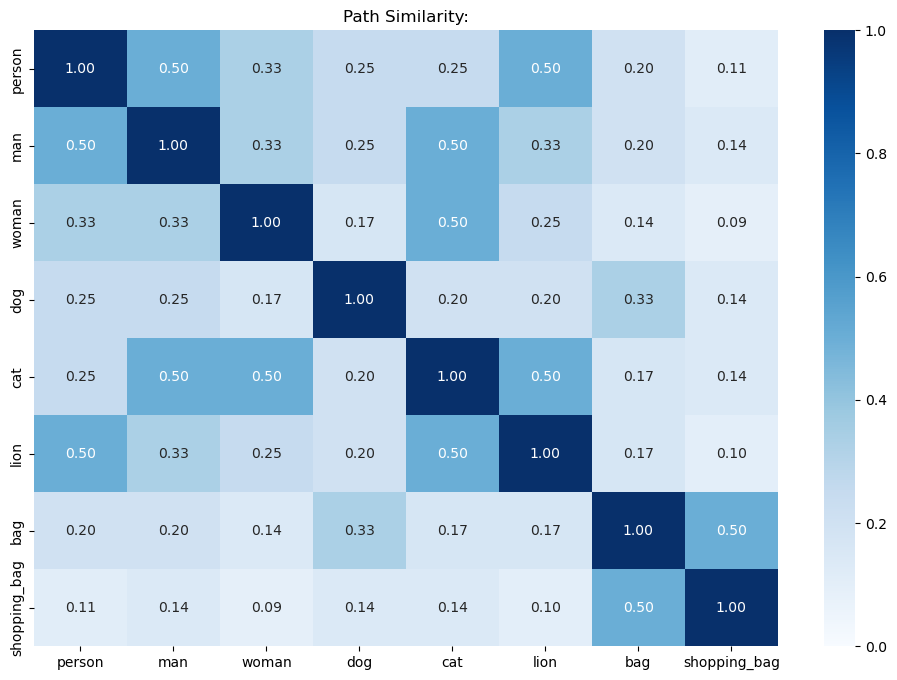

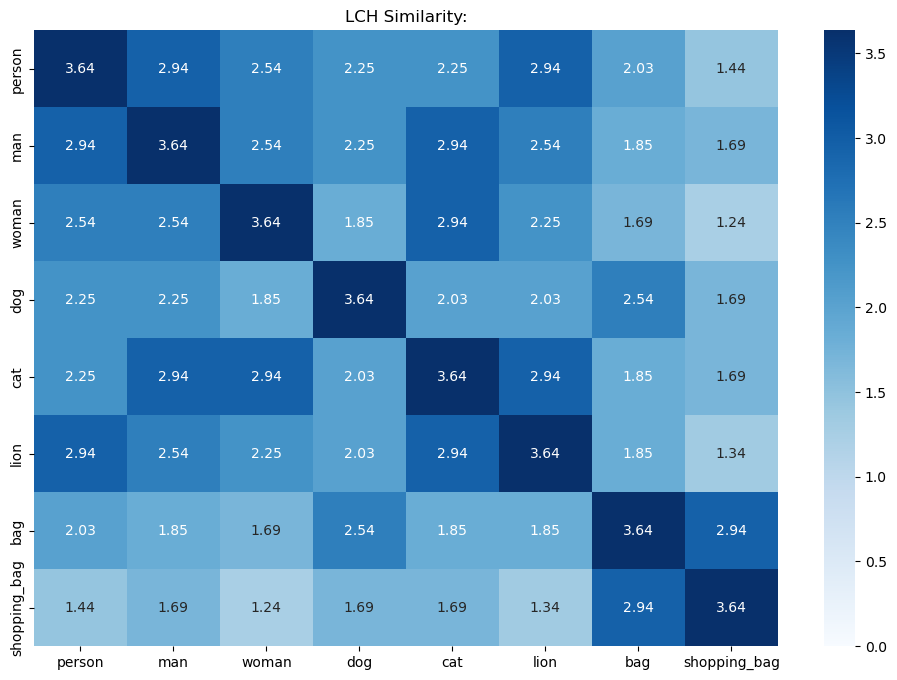

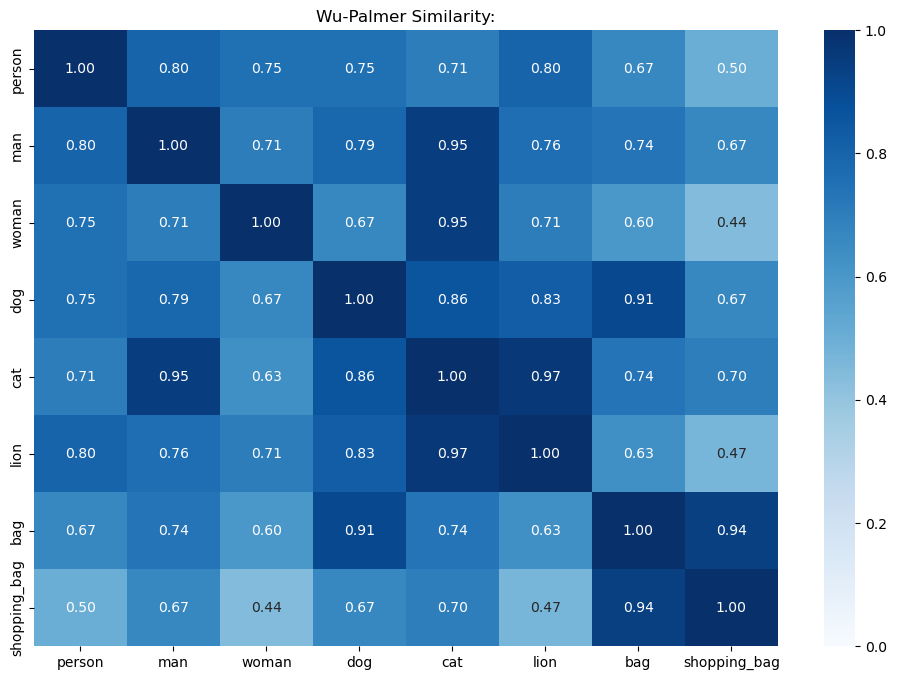

In [66]:
words = ['person', 'man', 'woman', 'dog', 'cat', 'lion', 'bag', 'shopping_bag']

sim_compute = lambda sim_f, words: [[sim_f(w1, w2) for w2 in words] for w1 in words]


path_sim = np.array(sim_compute(path_similarity, words))
lch_sim = np.array(sim_compute(lch_similarity, words))
wup_sim = np.array(sim_compute(wup_similarity, words))

plt.figure(figsize=(12, 8))
sns.heatmap(path_sim, annot=True, xticklabels=words, yticklabels=words, fmt=".2f", cmap="Blues", vmin=0, vmax=1)
plt.title(f"Path Similarity:")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(lch_sim, annot=True, xticklabels=words, yticklabels=words, fmt=".2f", cmap="Blues", vmin=0, vmax=np.max(lch_sim))
plt.title(f"LCH Similarity:")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(wup_sim, annot=True, xticklabels=words, yticklabels=words, fmt=".2f", cmap="Blues", vmin=0, vmax=1)
plt.title(f"Wu-Palmer Similarity:")
plt.show()



Redefine recall to take similarity in consideration

In [67]:
def recall_at_k(gt, pred, sim_fun=None, thresh=None, k=10):
    o1 = set([sg[0] for sg in gt])
    rel = set([sg[1] for sg in gt])
    o2 = set([sg[2] for sg in gt])
    
    o1_pred = set([sg[0] for sg in pred])
    rel_pred = set([sg[1] for sg in pred])
    o2_pred = set([sg[2] for sg in pred if len(sg) > 2])
    
    if sim_fun:
        def sim_compute(gt_words, pred_words):
            # if we find a word similar to that of the ground truth
            # we consider it a match and break the iteration at the
            # first match we find
            matches = []
            for gt_word in gt_words:
                for pred in pred_words:
                    if sim_fun(gt_word, pred) > thresh:
                        matches.append(1)
                        break

            return sum(matches)

        o1_intersection = sim_compute(o1, o1_pred)
        rel_intersection = sim_compute(rel, rel_pred)
        o2_intersection = sim_compute(o2, o2_pred)
    else:
        o1_intersection = len(o1.intersection(o1_pred))
        rel_intersection = len(rel.intersection(rel_pred))
        o2_intersection = len(o2.intersection(o2_pred))
    
    o1_recall = o1_intersection/len(o1)
    rel_recall = rel_intersection/len(rel)
    o2_recall = o2_intersection/len(o2)
    
    # TODO: missing a reflexivity relation where o1 - rel1 - o2 might be equivaletn to o2 - rel2 - o1
    
    return o1_recall, rel_recall, o2_recall

def average_recall(situation_id, gt_dict, pred_dict, sim_fun=None, thresh=None, k=10):
    
    mean_o1 = 0
    mean_rel = 0
    mean_o2 = 0
    for i, frame_id in enumerate(pred_dict[situation_id]):
        # Previously we filterd some frames in the gt beacuse
        # there were no SG annotation, which yieled division by
        # zero because o1, rel, o2 are empty
        if frame_id not in pred_dict[situation_id] \
            or frame_id not in  gt_dict[situation_id]:
            continue
        pred_sg = pred_dict[situation_id][frame_id]
        gt_sg = gt_dict[situation_id][frame_id]
        o1_recall, rel_recall, o2_recall = recall_at_k(gt_sg, pred_sg, sim_fun, thresh, k)
        
        mean_o1 = (i * mean_o1 + o1_recall) / (i + 1)
        mean_rel = (i * mean_rel + rel_recall) / (i + 1)
        mean_o2 = (i * mean_o2 + o2_recall) / (i + 1)
        
    return mean_o1, mean_rel, mean_o2

test_id = 'Sequence_T1_5008' 
o1_recall, rel_recall, o2_recall = recall_at_k(STAR_data_df.loc[test_id]['stsg']['000019'], struct_gen_graphs[test_id]['000019'])

print(f"Eval for id {test_id} - frame {'000019'} with exact matching")
print(f"{'- Recall (o1)':<15}: {o1_recall:.3f}")
print(f"{'- Recall (rel)':<15}: {rel_recall:.3f}")
print(f"{'- Recall (o2)':<15}: {o2_recall:.3f}")
print()


o1_recall, rel_recall, o2_recall = recall_at_k(STAR_data_df.loc[test_id]['stsg']['000019'], struct_gen_graphs[test_id]['000019'], wup_similarity, 0.75)

print(f"Eval for id {test_id} - frame {'000019'} with similarity smoothing")
print(f"{'- Recall (o1)':<15}: {o1_recall:.3f}")
print(f"{'- Recall (rel)':<15}: {rel_recall:.3f}")
print(f"{'- Recall (o2)':<15}: {o2_recall:.3f}")
print()


Eval for id Sequence_T1_5008 - frame 000019 with exact matching
- Recall (o1)  : 0.000
- Recall (rel) : 0.667
- Recall (o2)  : 0.000

Eval for id Sequence_T1_5008 - frame 000019 with similarity smoothing
- Recall (o1)  : 1.000
- Recall (rel) : 0.667
- Recall (o2)  : 1.000



In [68]:
o1_recall, rel_recall, o2_recall = average_recall(test_id, STAR_data_df['stsg'], struct_gen_graphs)

print(f"Eval for id {test_id} - frame {'000019'} with exact matching")
print(f"{'- Recall (o1)':<15}: {o1_recall:.3f}")
print(f"{'- Recall (rel)':<15}: {rel_recall:.3f}")
print(f"{'- Recall (o2)':<15}: {o2_recall:.3f}")
print()


o1_recall, rel_recall, o2_recall = average_recall(test_id, STAR_data_df['stsg'], struct_gen_graphs, wup_similarity, 0.75)

print(f"Eval for id {test_id} - frame {'000019'} with similarity smoothing")
print(f"{'- Recall (o1)':<15}: {o1_recall:.3f}")
print(f"{'- Recall (rel)':<15}: {rel_recall:.3f}")
print(f"{'- Recall (o2)':<15}: {o2_recall:.3f}")
print()


Eval for id Sequence_T1_5008 - frame 000019 with exact matching
- Recall (o1)  : 0.000
- Recall (rel) : 0.556
- Recall (o2)  : 0.315

Eval for id Sequence_T1_5008 - frame 000019 with similarity smoothing
- Recall (o1)  : 1.000
- Recall (rel) : 0.546
- Recall (o2)  : 0.926



In [69]:
mean_o1 = 0
mean_rel = 0
mean_o2 = 0
o2s = []
for i, situation_id in enumerate(struct_gen_graphs.index):
    o1_recall, rel_recall, o2_recall = average_recall(situation_id, STAR_data_df['stsg'], struct_gen_graphs)
    
    o2s.append(o2_recall)
    mean_o1 = (i * mean_o1 + o1_recall) / (i + 1)
    mean_rel = (i * mean_rel + rel_recall) / (i + 1)
    mean_o2 = (i * mean_o2 + o2_recall) / (i + 1)

print(f"Eval with exact matching")
print(f"{'- Recall (o1)':<15}: {mean_o1:.3f}")
print(f"{'- Recall (rel)':<15}: {mean_rel:.3f}")
print(f"{'- Recall (o2)':<15}: {mean_o2:.3f}")
print()

mean_o1 = 0
mean_rel = 0
mean_o2 = 0
o2s = []
for i, situation_id in enumerate(struct_gen_graphs.index):
    o1_recall, rel_recall, o2_recall = average_recall(situation_id, STAR_data_df['stsg'], struct_gen_graphs,  wup_similarity, 0.75)
    
    o2s.append(o2_recall)
    mean_o1 = (i * mean_o1 + o1_recall) / (i + 1)
    mean_rel = (i * mean_rel + rel_recall) / (i + 1)
    mean_o2 = (i * mean_o2 + o2_recall) / (i + 1)

print(f"Eval with similarity smoothing")
print(f"{'- Recall (o1)':<15}: {mean_o1:.3f}")
print(f"{'- Recall (rel)':<15}: {mean_rel:.3f}")
print(f"{'- Recall (o2)':<15}: {mean_o2:.3f}")

# TODO
# computing the similarity with sim_fun in this manner is too slow
#
# SUGGESTION: 
# compute the similarity matrix with all the object beforehand
# and then access it when it's needed
#
# NOTE:
# all the object/rel present in the ground-truth data set
# are stored in the classes/vocab files
# for the pred an iteration over all objects/rels is needed



Eval with exact matching
- Recall (o1)  : 0.064
- Recall (rel) : 0.254
- Recall (o2)  : 0.189

Eval with similarity smoothing
- Recall (o1)  : 0.403
- Recall (rel) : 0.297
- Recall (o2)  : 0.477


We got an improvment but not that substanial, let's analyze the similarity between gorund truth object/relation with the predict one. 

Let's start with the ground truth object vocabulary

In [70]:
obj_vocab


{'o000': 'person',
 'o001': 'broom',
 'o002': 'picture',
 'o003': 'closet/cabinet',
 'o004': 'blanket',
 'o005': 'window',
 'o006': 'table',
 'o007': 'paper/notebook',
 'o008': 'refrigerator',
 'o009': 'pillow',
 'o010': 'cup/glass/bottle',
 'o011': 'shelf',
 'o012': 'shoe',
 'o013': 'medicine',
 'o014': 'phone/camera',
 'o015': 'box',
 'o016': 'sandwich',
 'o017': 'book',
 'o018': 'bed',
 'o019': 'clothes',
 'o020': 'mirror',
 'o021': 'sofa/couch',
 'o022': 'floor',
 'o023': 'bag',
 'o024': 'dish',
 'o025': 'laptop',
 'o026': 'door',
 'o027': 'towel',
 'o028': 'food',
 'o029': 'chair',
 'o030': 'doorknob',
 'o031': 'doorway',
 'o032': 'groceries',
 'o033': 'hands',
 'o034': 'light',
 'o035': 'vacuum',
 'o036': 'television'}

37 object classes, in the paper they mentioned 28 objects

In [71]:
rel_vocab


{'r000': 'on',
 'r001': 'behind',
 'r002': 'in_front_of',
 'r003': 'on_the_side_of',
 'r004': 'above',
 'r005': 'beneath',
 'r006': 'drinking_from',
 'r007': 'have_it_on_the_back',
 'r008': 'wearing',
 'r009': 'holding',
 'r010': 'lying_on',
 'r011': 'covered_by',
 'r012': 'carrying',
 'r013': 'eating',
 'r014': 'leaning_on',
 'r015': 'sitting_on',
 'r016': 'twisting',
 'r017': 'writing_on',
 'r018': 'standing_on',
 'r019': 'touching',
 'r020': 'wiping',
 'r021': 'at',
 'r022': 'under',
 'r023': 'near'}

24 relationship classes, the same number mentioned in the paper

In the object voc we have objecst in the form obj1/obj2 etc, let's see if it is compatible with the wordnet interface

In [72]:
wn.synsets('paper/notebook')


[]

As imagined, Wordnet cannot handle these case, we have to do it manually

In [73]:

gt_obj_words = [word for o in obj_vocab.values() for word in o.split('/')]

len(gt_obj_words)


43

In [74]:
def word_similarity(x_words, similarity="path", y_words=None, sim_fun=None):
    """
        similarity:
            "path" | "lch" | "wup"
    """
    if not y_words:
        y_words = x_words
        
    if not sim_fun:
        if similarity == 'path':
            sim_fun = path_similarity
        elif similarity == 'lch':
            sim_fun = lch_similarity
        elif similarity == 'wup':
            sim_fun = wup_similarity
        else:
            raise ValueError(f"{similarity} is not a valid similarity metric")
        
    sim_matrix = np.array([[sim_fun(w1, w2) for w2 in y_words] for w1 in x_words])

    return sim_matrix

def sim_heatmap(sim_matrix, words, words2=None, **kwargs):

    if not words2:
        words2 = words
        
    # set default if not defined
    kwargs.setdefault("cmap", "Blues")
    kwargs.setdefault("annot", False)
    kwargs.setdefault("linewidth", 0.5)
    kwargs.setdefault("linecolor", "white")
    kwargs.setdefault("fmt", ".02f")
    
    
    plt.figure(figsize=(16, 12))
    sns.heatmap(sim_matrix,
                xticklabels=words,
                yticklabels=words2,
                **kwargs
        )
    plt.title(f"Similarity matrix:")
    plt.show()


In [75]:
path_sim = word_similarity(gt_obj_words, similarity='path')
lch_sim = word_similarity(gt_obj_words, similarity='lch')
wup_sim = word_similarity(gt_obj_words, similarity='wup')


Now we can visualize a similarity matrix to discern similar concetps at a glance and inspect the effect of different similarity functions:

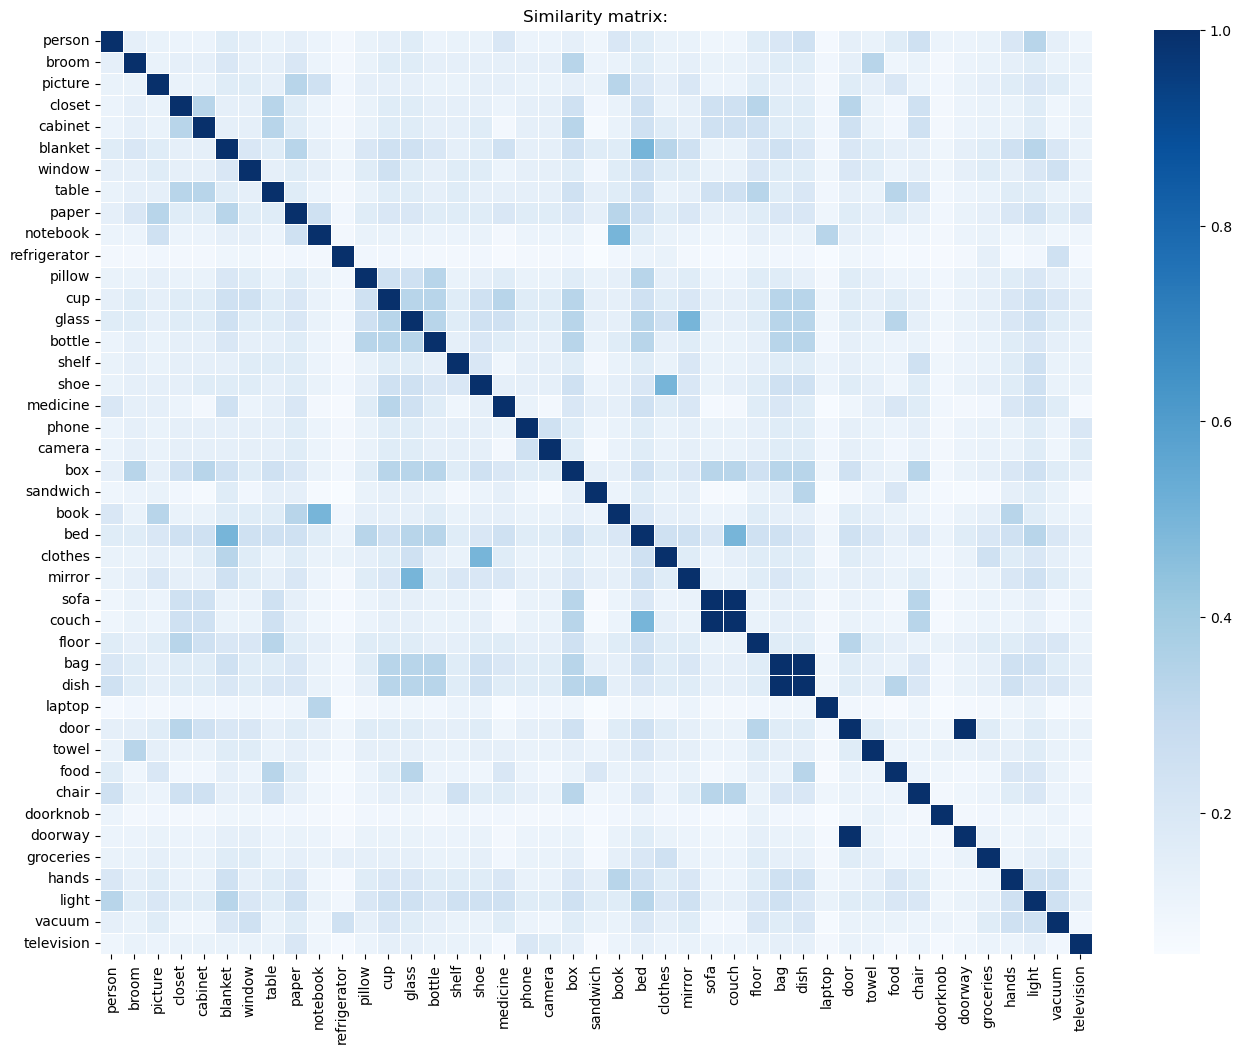

In [76]:
from matplotlib.colors import TwoSlopeNorm, LogNorm

sim_heatmap(path_sim, gt_obj_words, cmap="Blues")


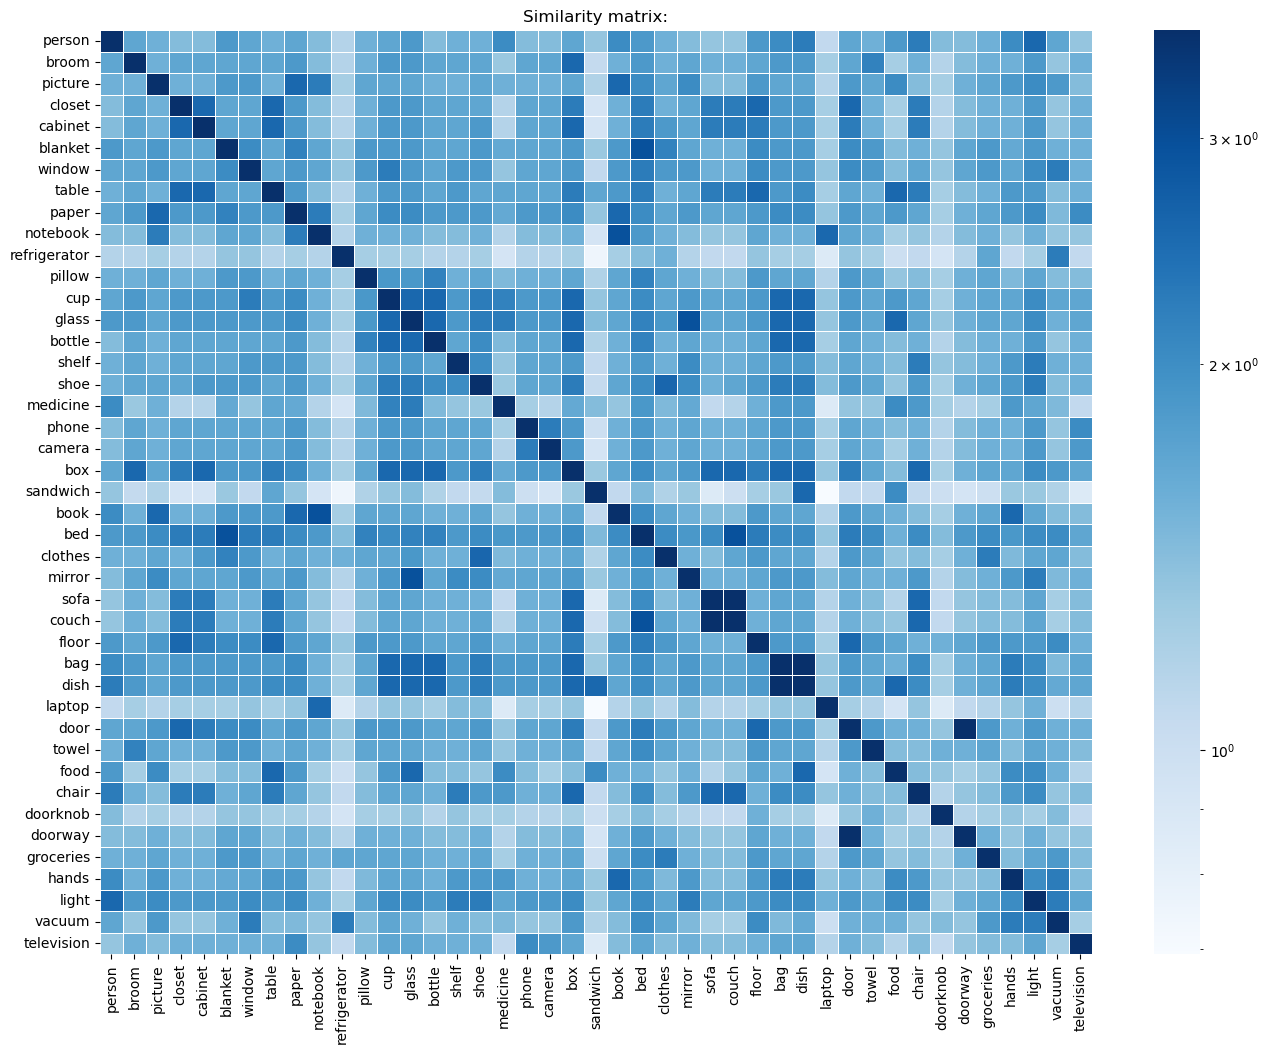

In [77]:
from matplotlib.colors import LogNorm

# Using log scale for lch since is a log based sim function
sim_heatmap(lch_sim, gt_obj_words, cmap="Blues", norm=LogNorm())


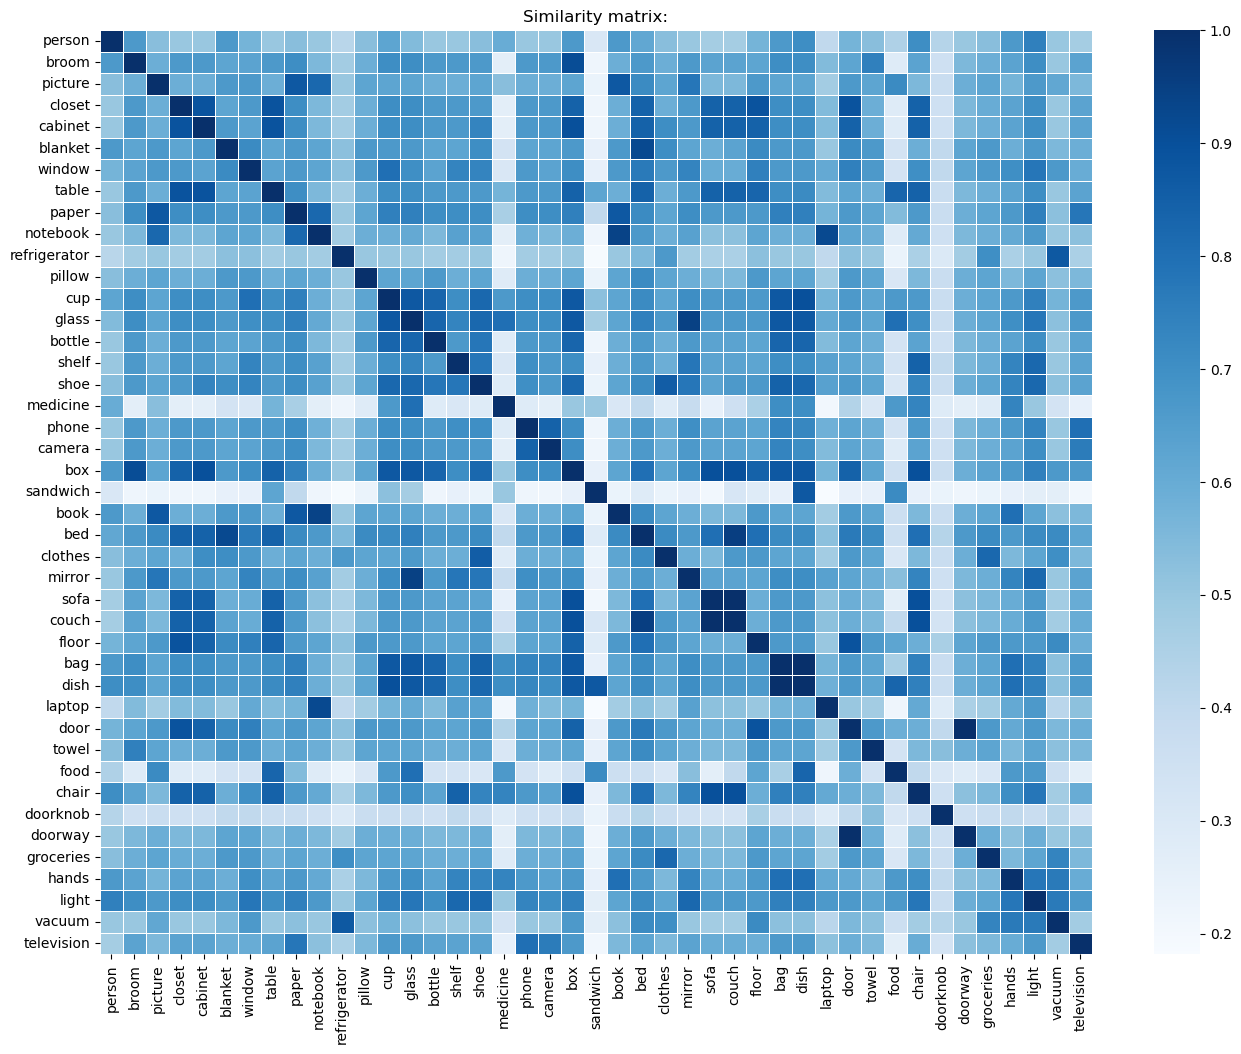

In [78]:
sim_heatmap(wup_sim, gt_obj_words, cmap="Blues")


### Introducing a threshold

Now we see what items would be considered simialr when introducing a threshold

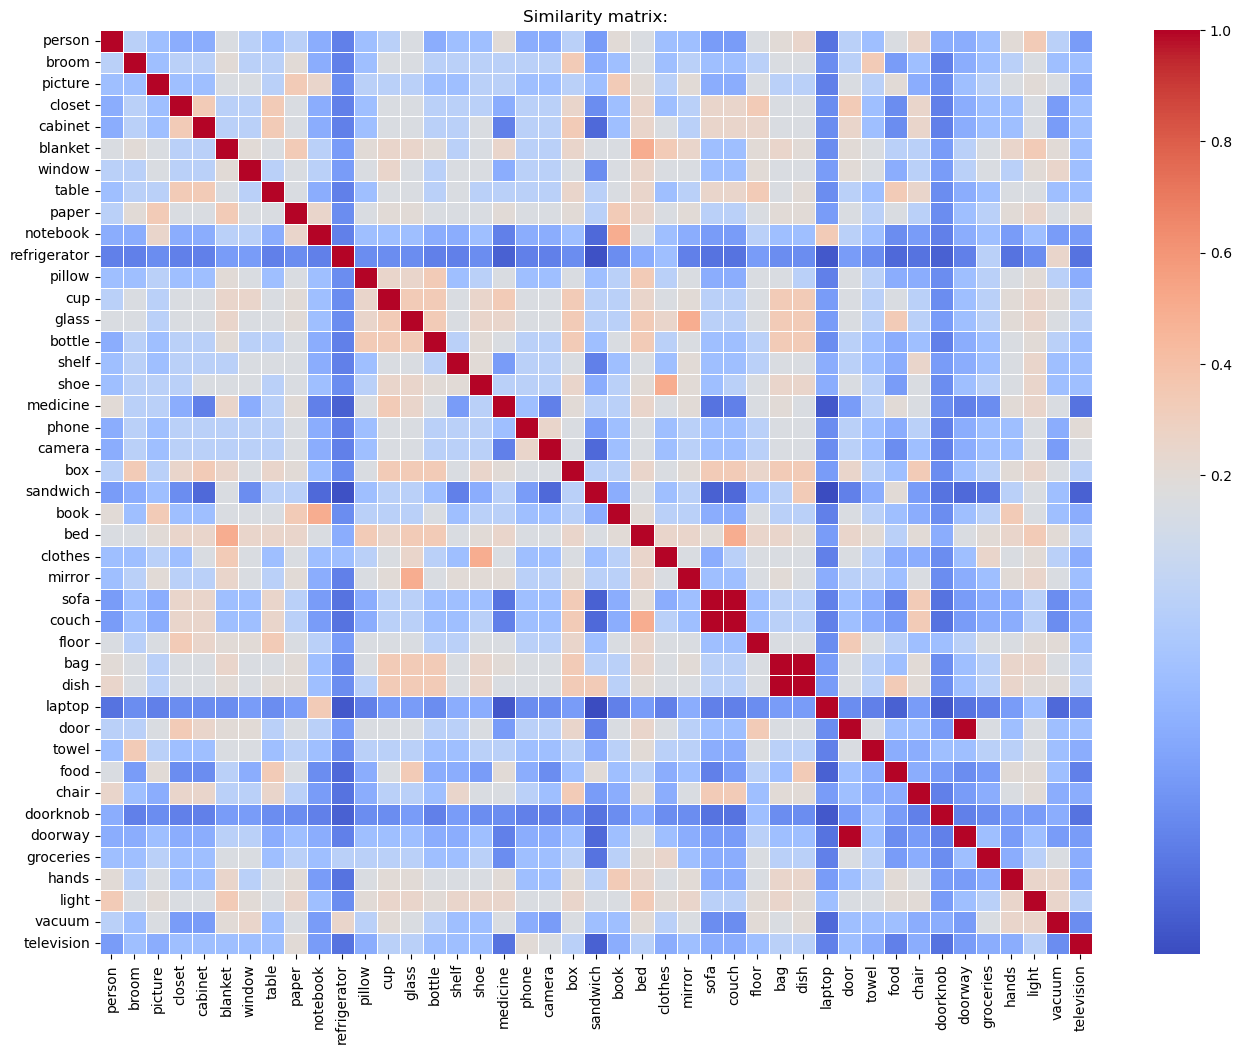

In [79]:
# path similarity is defined as 1/(1+p)
# it's possible values are: 1, 0.5, 0.33, .025, 0.20, 0.166, ...
# therfore a low threshold is required to capture broader
# semantic similarity

threshold = 0.17
norm = TwoSlopeNorm(vcenter=threshold)
sim_heatmap(path_sim, gt_obj_words, cmap="coolwarm", norm=norm)


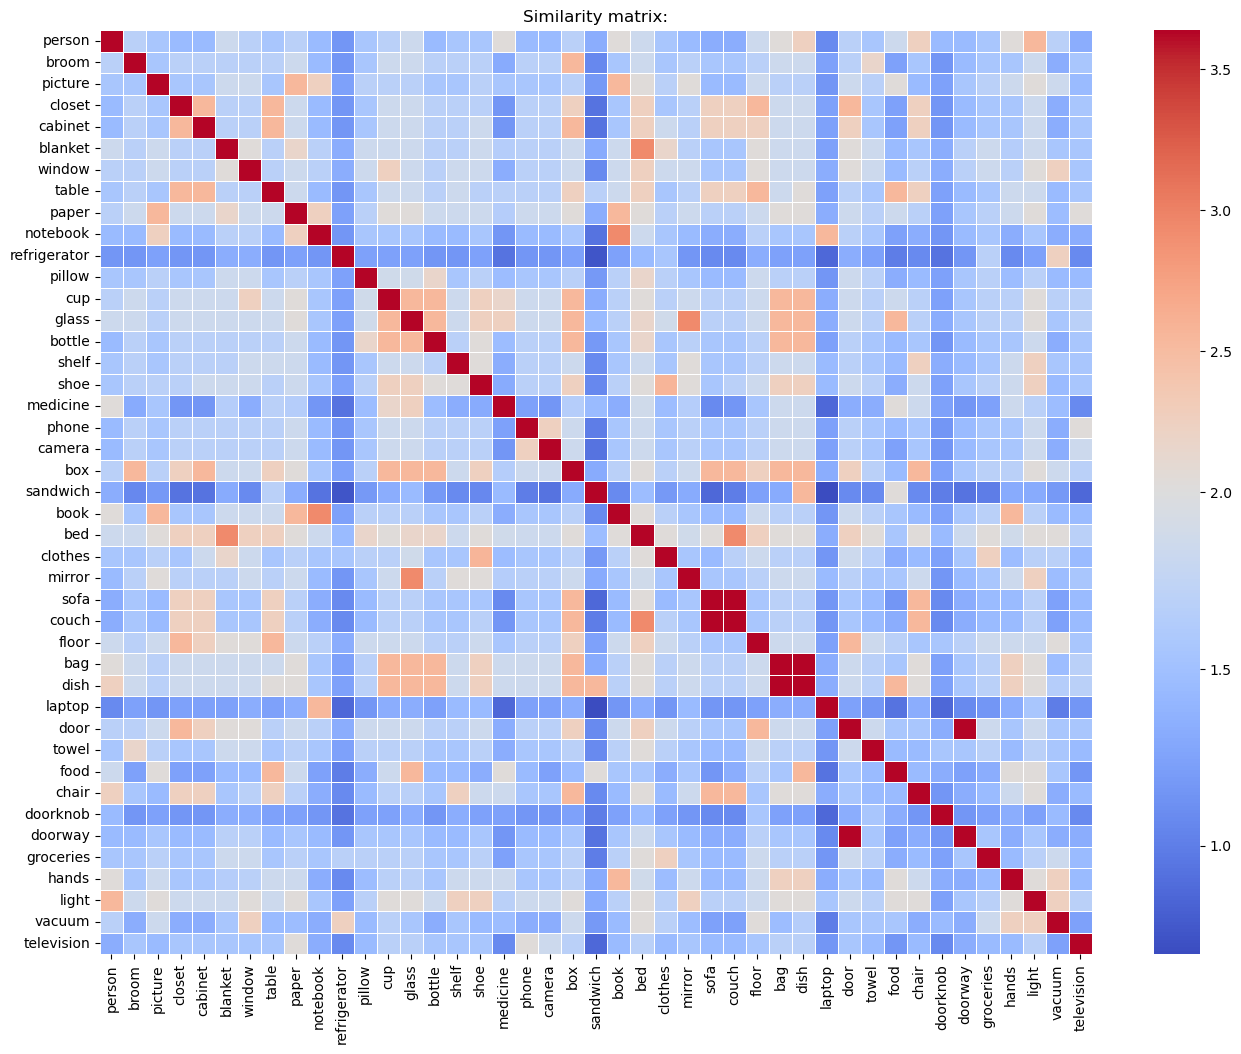

In [80]:
threshold = 2.0
norm = TwoSlopeNorm(vcenter=threshold)
sim_heatmap(lch_sim, gt_obj_words, cmap="coolwarm", norm=norm)


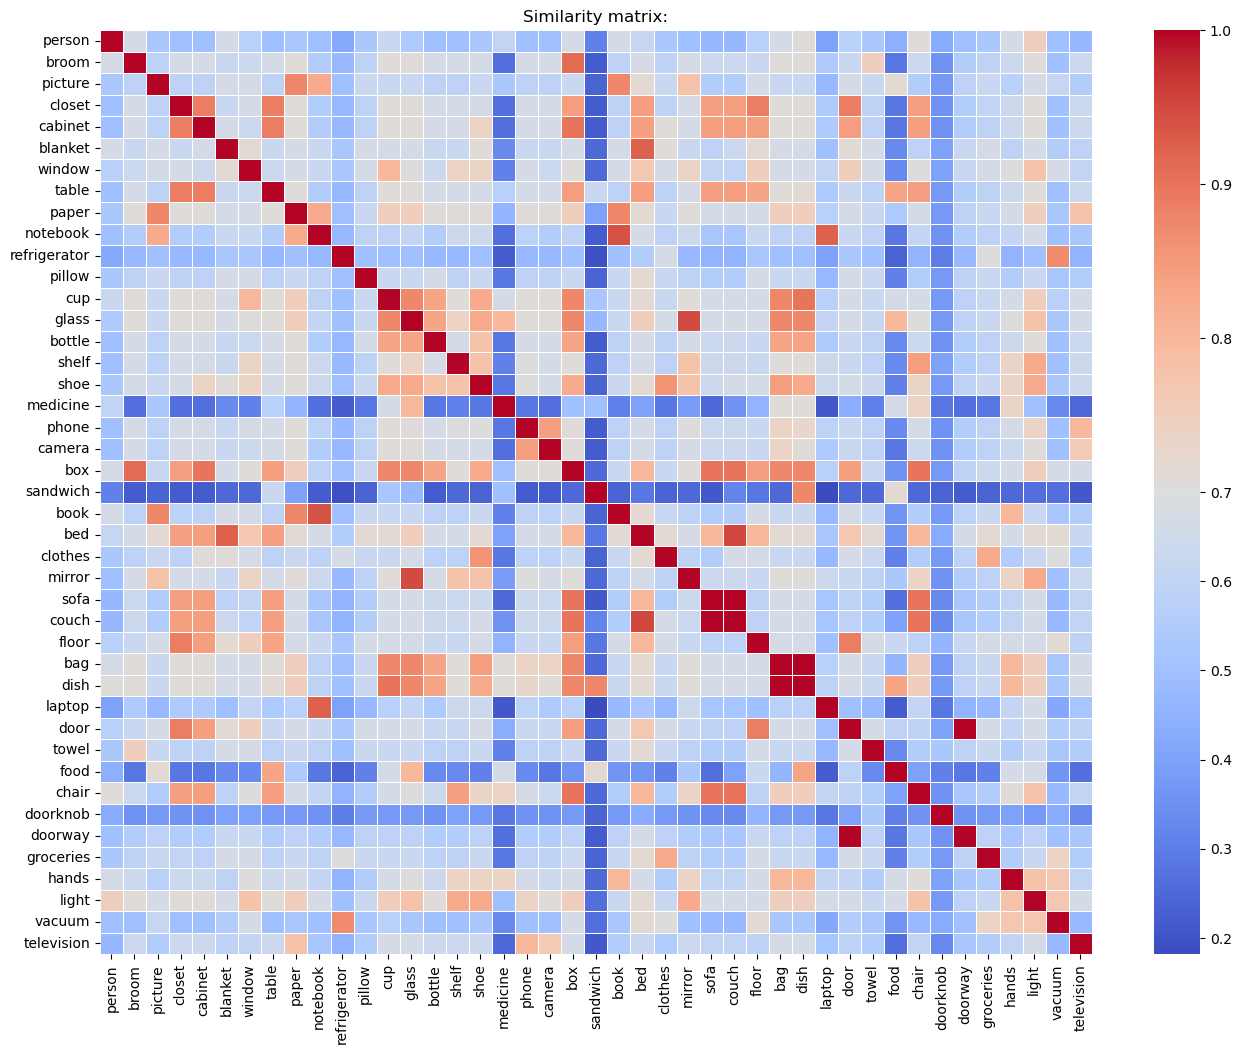

In [81]:
threshold = 0.7
norm = TwoSlopeNorm(vcenter=threshold)
sim_heatmap(wup_sim, gt_obj_words, cmap="coolwarm", norm=norm)


We can also compute the hierachical clustering between the words, to have a first view of how similar concept are grouped together. 

CAREFUL
The y-axis of the plot indicates the distance between words computed as (1 - similarity)

{'icoord': [[45.0, 45.0, 55.0, 55.0],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [75.0, 75.0, 92.5, 92.5],
  [65.0, 65.0, 83.75, 83.75],
  [185.0, 185.0, 195.0, 195.0],
  [225.0, 225.0, 235.0, 235.0],
  [255.0, 255.0, 265.0, 265.0],
  [245.0, 245.0, 260.0, 260.0],
  [275.0, 275.0, 285.0, 285.0],
  [345.0, 345.0, 355.0, 355.0],
  [335.0, 335.0, 350.0, 350.0],
  [325.0, 325.0, 342.5, 342.5],
  [385.0, 385.0, 395.0, 395.0],
  [375.0, 375.0, 390.0, 390.0],
  [365.0, 365.0, 382.5, 382.5],
  [333.75, 333.75, 373.75, 373.75],
  [315.0, 315.0, 353.75, 353.75],
  [305.0, 305.0, 334.375, 334.375],
  [295.0, 295.0, 319.6875, 319.6875],
  [280.0, 280.0, 307.34375, 307.34375],
  [252.5, 252.5, 293.671875, 293.671875],
  [230.0, 230.0, 273.0859375, 273.0859375],
  [215.0, 215.0, 251.54296875, 251.54296875],
  [205.0, 205.0, 233.271484375, 233.271484375],
  [190.0, 190.0, 219.1357421875, 219.1357421875],
  [175.0, 175.0, 204.56787109375, 204.56787109375],
  [165.0, 165.0, 189.78393

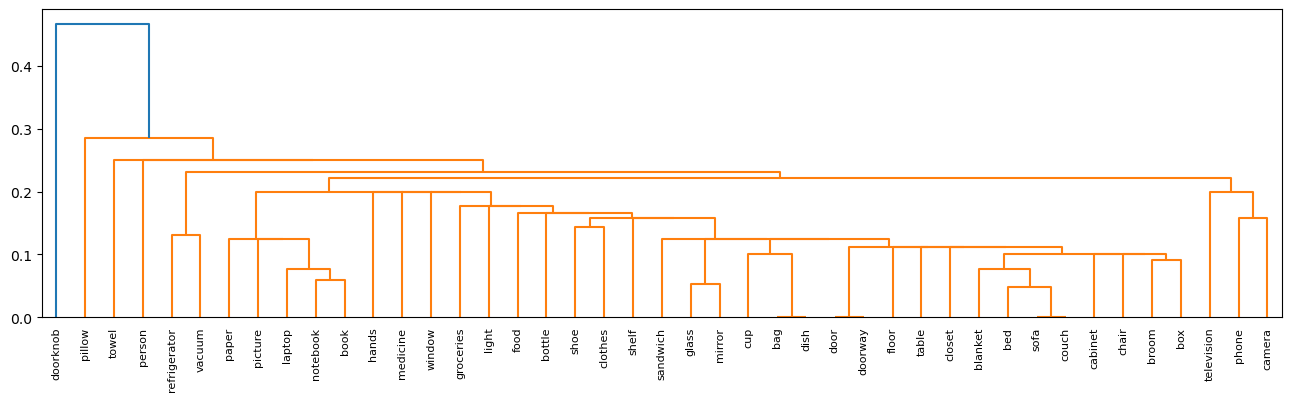

In [82]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

distance_matrix = 1 - wup_sim

# Perform hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='single')

plt.figure(figsize=(16, 4))
dendrogram(
    linkage_matrix,
    labels=gt_obj_words,
    distance_sort=False,
)


### Do the same for predicted objects

In [83]:
pred_object_words = []
pred_rel_words = []

for situation in struct_gen_graphs:
    for _, sg in situation.items():
        for triplet in sg:
            
            pred_object_words.append(triplet[0])
            pred_rel_words.append(triplet[1])
            
            if len(triplet) > 2:
                pred_object_words.append(triplet[2])

pred_obj_words_raw = set(pred_object_words)
pred_rel_words_raw = set(pred_rel_words)

print("Total predicted object vocabulary: ", len(pred_obj_words_raw))
print("Total predicted object vocabulary: ", len(pred_rel_words_raw))


Total predicted object vocabulary:  3844
Total predicted object vocabulary:  1818


In [84]:
pred_obj_words_raw


{'',
 'abstract',
 'man5',
 'concrete_floor',
 'white_dress',
 'silver_lid',
 'black_and_white_patterned_pillow',
 'love',
 'red_white_ornament',
 'cup6',
 'sticky_note1',
 'ingredients_containers',
 'man’s_legs',
 'television_screen',
 'serving_dish',
 'man_redshirt',
 'green_top',
 'floor_reflection',
 'washing_machine_door',
 'upper_portion_of_image',
 'blue_storage_bin',
 'small_plate',
 'abstract_design',
 'wooden_frame_with_clock',
 'reading',
 'hair',
 'pink_cup',
 'white_plastic_sheet',
 'pink_item',
 'curtain_rod',
 'row',
 'ring',
 'checkered_box',
 'shadow_on',
 'ramen_noodle_box',
 'metal_support_structure',
 'tall_wooden_post',
 'silver_object',
 'quilted_chair',
 'black_color',
 'paper_card',
 'lamp_shadow',
 'white_plastic_tube',
 'glass_jar',
 'leather_bag',
 'orange_socks',
 'cube',
 'washing_machine_sink',
 'literature',
 'yellow_curtain',
 'camera_strap',
 'pink_dress',
 'blue_shirt',
 'poster5',
 'red_chair_cushion',
 'dark_shirt',
 'black_backpack',
 'bowl7',
 'col

In [85]:
obj_vocab


{'o000': 'person',
 'o001': 'broom',
 'o002': 'picture',
 'o003': 'closet/cabinet',
 'o004': 'blanket',
 'o005': 'window',
 'o006': 'table',
 'o007': 'paper/notebook',
 'o008': 'refrigerator',
 'o009': 'pillow',
 'o010': 'cup/glass/bottle',
 'o011': 'shelf',
 'o012': 'shoe',
 'o013': 'medicine',
 'o014': 'phone/camera',
 'o015': 'box',
 'o016': 'sandwich',
 'o017': 'book',
 'o018': 'bed',
 'o019': 'clothes',
 'o020': 'mirror',
 'o021': 'sofa/couch',
 'o022': 'floor',
 'o023': 'bag',
 'o024': 'dish',
 'o025': 'laptop',
 'o026': 'door',
 'o027': 'towel',
 'o028': 'food',
 'o029': 'chair',
 'o030': 'doorknob',
 'o031': 'doorway',
 'o032': 'groceries',
 'o033': 'hands',
 'o034': 'light',
 'o035': 'vacuum',
 'o036': 'television'}

In [86]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_text(text, remove_stopwords=True, lemmatize=True):

    # Lowercase
    text = text.lower()
    
    # Remove possessives ('s)
    text = re.sub(r"'s\b", "", text)
    
    # Split underscore-connected words
    text = re.sub(r"_", " ", text)
    
    # Split alternative with \ /
    text = re.sub(r"[\\/]", " ", text)
    
    # Replace different apostrophe symbols with the python standard
    text = re.sub("[\u2018-\u201b]", '\'', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # remove digits
    text = re.sub("\d", "", text)
    
    # Tokenize
    words = word_tokenize(text)
    
    # Optional: Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
    
    # Optional: Lemmatization
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

sample_text = "The cat's tail is fluffy. The quick_brown_fox jumps over the lazy_dog. Don't worry!"
print("Original text:", sample_text)
processed_text = preprocess_text(sample_text)
print("Processed text:", processed_text)


Original text: The cat's tail is fluffy. The quick_brown_fox jumps over the lazy_dog. Don't worry!
Processed text: cat tail fluffy quick brown fox jump lazy dog dont worry


In [87]:
# Need to keep list + dict to also access the index
# in the similarity matrix

sanitized_pred_obj_vocab = []
raw_to_sanitized_idx = {}
for i, text in enumerate(pred_obj_words_raw):
    sanitized_pred_obj_vocab.append(preprocess_text(text))
    raw_to_sanitized_idx[text] = i
    
sanitized_pred_obj_vocab


['',
 'abstract',
 'man',
 'concrete floor',
 'white dress',
 'silver lid',
 'black white patterned pillow',
 'love',
 'red white ornament',
 'cup',
 'sticky note',
 'ingredient container',
 'man leg',
 'television screen',
 'serving dish',
 'man redshirt',
 'green top',
 'floor reflection',
 'washing machine door',
 'upper portion image',
 'blue storage bin',
 'small plate',
 'abstract design',
 'wooden frame clock',
 'reading',
 'hair',
 'pink cup',
 'white plastic sheet',
 'pink item',
 'curtain rod',
 'row',
 'ring',
 'checkered box',
 'shadow',
 'ramen noodle box',
 'metal support structure',
 'tall wooden post',
 'silver object',
 'quilted chair',
 'black color',
 'paper card',
 'lamp shadow',
 'white plastic tube',
 'glass jar',
 'leather bag',
 'orange sock',
 'cube',
 'washing machine sink',
 'literature',
 'yellow curtain',
 'camera strap',
 'pink dress',
 'blue shirt',
 'poster',
 'red chair cushion',
 'dark shirt',
 'black backpack',
 'bowl',
 'color',
 'red couch cushion',

In [88]:
# Define a new similarity computation function to handle multiple words
# 
# Compute a similarity matrix between words or word groups, handling both single-word
# and multi-word comparisons. When comparing:
# - Single word vs single word: Direct similarity score
# - Word list vs single word: Max similarity across all word pairs
# - Single word vs word list: Max similarity across all word pairs
# - Word list vs word list: Max similarity across all combinations

def compute_sim_matrix(row_words, column_words=None, sim_fun=None, similarity="path", level=0):
    """
    Compute a pairwise similarity matrix between words or groups of words.

    This function supports comparing:
    - A single word vs. a single word (direct similarity).
    - A list of words vs. a single word (max similarity across all word pairs).
    - A single word vs. a list of words (max similarity across all word pairs).
    - A list of words vs. a list of words (max similarity across all combinations).

    Args:
        r_words (str, list[str], or list[list[str]]): Reference words to compare.
            If a list of lists, each sublist represents a multi-word group.
        similarity (str, optional): Similarity metric type. Must be one of:
            "path" (default) | "lch" | "wup".
        c_words (str, list[str], or list[list[str]], optional): Comparison words.
            If None (default), uses r_words for self-comparison.
        sim_fun (callable, optional): Custom similarity function with signature
            sim_fun(word1: str, word2: str) -> float. Overrides `similarity`.

    Returns:
        np.ndarray: Similarity matrix of shape (len(r_words), len(c_words)),
        where each entry [i,j] contains the maximum similarity between the i-th
        reference word/group and the j-th comparison word/group.

    Example:
        >>> compute_sim_matrix(["bank", ["river", "stream"]], c_words=["finance", "water"])
        array([[0.7, 0.3],   # "bank" vs "finance"=0.7, "bank" vs "water"=0.3
               [0.2, 0.9]])  # max("river"/"stream" vs "finance")=0.2, vs "water"=0.9
    """

    if not column_words:
        column_words = row_words
        
    if not sim_fun:
        if similarity == 'path':
            sim_fun = path_similarity
        elif similarity == 'lch':
            sim_fun = lch_similarity
        elif similarity == 'wup':
            sim_fun = wup_similarity
        else:
            raise ValueError(f"{similarity} is not a valid similarity metric")
        
    sim_matrix = np.zeros((len(row_words), len(column_words)))
    
    # Only show progress bar for the top-level call (level=0)
    iterator = tqdm(row_words, desc="Computing similarities") if level == 0 else row_words
    
    for i, w1 in enumerate(iterator):
        for j, w2 in enumerate(column_words):
            if isinstance(w1, list):
                # wrap w2 in a list if it is a single word
                w2 = w2 if isinstance(w2, list) else [w2]
                sim_matrix[i][j] = np.max(
                    compute_sim_matrix(
                        w1,
                        w2,
                        sim_fun=sim_fun,
                        level=level+1,
                    )
                )
            elif isinstance(w2, list):
                sim_matrix[i][j] = np.max(
                    compute_sim_matrix(
                        [w1], # if we are in this branch w1 must be a string
                        w2,
                        sim_fun=sim_fun,
                        level=level+1,
                        
                    )
                )
            else:
                sim_matrix[i][j] = sim_fun(w1, w2)
                    
    return sim_matrix


In [89]:
compute_sim_matrix([['man', 'woman'], 'person'], similarity='wup')


Computing similarities: 100%|██████████| 2/2 [00:00<00:00, 37.02it/s]


array([[1. , 0.8],
       [0.8, 1. ]])

In [90]:
compute_sim_matrix(['man', 'woman'], ['person'], similarity='wup')


Computing similarities: 100%|██████████| 2/2 [00:00<00:00, 257.45it/s]


array([[0.8 ],
       [0.75]])

In [91]:
gt_obj_vocab = get_vocab_map(WORK_DIR / 'data/datasets/STAR/STAR_annotations/class_maps/object_classes.txt')
gt_obj_words = [preprocess_text(word).split(' ') for word in obj_vocab.values()]
gt_obj_words


[['person'],
 ['broom'],
 ['picture'],
 ['closet', 'cabinet'],
 ['blanket'],
 ['window'],
 ['table'],
 ['paper', 'notebook'],
 ['refrigerator'],
 ['pillow'],
 ['cup', 'glass', 'bottle'],
 ['shelf'],
 ['shoe'],
 ['medicine'],
 ['phone', 'camera'],
 ['box'],
 ['sandwich'],
 ['book'],
 ['bed'],
 ['clothes'],
 ['mirror'],
 ['sofa', 'couch'],
 ['floor'],
 ['bag'],
 ['dish'],
 ['laptop'],
 ['door'],
 ['towel'],
 ['food'],
 ['chair'],
 ['doorknob'],
 ['doorway'],
 ['grocery'],
 ['hand'],
 ['light'],
 ['vacuum'],
 ['television']]

In [92]:
pred_obj_words = [w.split(" ") for w in sanitized_pred_obj_vocab]
pred_obj_words


[[''],
 ['abstract'],
 ['man'],
 ['concrete', 'floor'],
 ['white', 'dress'],
 ['silver', 'lid'],
 ['black', 'white', 'patterned', 'pillow'],
 ['love'],
 ['red', 'white', 'ornament'],
 ['cup'],
 ['sticky', 'note'],
 ['ingredient', 'container'],
 ['man', 'leg'],
 ['television', 'screen'],
 ['serving', 'dish'],
 ['man', 'redshirt'],
 ['green', 'top'],
 ['floor', 'reflection'],
 ['washing', 'machine', 'door'],
 ['upper', 'portion', 'image'],
 ['blue', 'storage', 'bin'],
 ['small', 'plate'],
 ['abstract', 'design'],
 ['wooden', 'frame', 'clock'],
 ['reading'],
 ['hair'],
 ['pink', 'cup'],
 ['white', 'plastic', 'sheet'],
 ['pink', 'item'],
 ['curtain', 'rod'],
 ['row'],
 ['ring'],
 ['checkered', 'box'],
 ['shadow'],
 ['ramen', 'noodle', 'box'],
 ['metal', 'support', 'structure'],
 ['tall', 'wooden', 'post'],
 ['silver', 'object'],
 ['quilted', 'chair'],
 ['black', 'color'],
 ['paper', 'card'],
 ['lamp', 'shadow'],
 ['white', 'plastic', 'tube'],
 ['glass', 'jar'],
 ['leather', 'bag'],
 ['oran

In [93]:
class WordNetSimilarity:
    
    def __init__(self):
        self.sim_matrix = None
        self.words_a_to_idx = None
        self.words_b_to_idx = None
    
    def fit(self, words_a, words_b, similarity='wup'):
        words_a = set(self.flatten(words_a))
        words_b = set(self.flatten(words_b))
        
        self.words_a_to_idx = {word: i for i, word in enumerate(words_a)}
        self.words_b_to_idx = {word: i for i, word in enumerate(words_b)}
        
        self.sim_matrix = compute_sim_matrix(words_a, words_b, similarity=similarity)
        
        return self.sim_matrix
    
    def similarity(self, a, b):
        
        # Ensure `a` and `b` are treated as sets of words (even if input as strings)
        a_words = set(a) if isinstance(a, str) else set(a)
        b_words = set(b) if isinstance(b, str) else set(b)
        
        
        a_indices = [v for k, v in self.words_a_to_idx.items() if k in a_words]
        b_indices = [v for k, v in self.words_b_to_idx.items() if k in b_words]
        
        # extract the block matrix identified by the
        # combination of all indices
        
        if not a_indices:
            raise ValueError(f'No entry for word {a}')
        elif not b_indices:
            raise ValueError(f'No entry for word {b}')
        
        a_indices = np.array(a_indices)[:,None]
        max = np.max(self.sim_matrix[a_indices, b_indices])
        
        return max   
                
    def flatten(self, list_of_words):
        flattened = []
        for words in list_of_words:
            if isinstance(words, str):
                flattened.append(words)
            elif isinstance(words, list):
                flattened += words
            else:
                raise ValueError("Unexpected object of other type than list or string")
        return flattened


In [94]:
wordnet_sim_obj = WordNetSimilarity()
sim_mat = wordnet_sim_obj.fit(gt_obj_words, pred_obj_words, similarity="wup")


Computing similarities: 100%|██████████| 43/43 [01:31<00:00,  2.14s/it]


In [95]:
mean_o1 = 0
mean_rel = 0
mean_o2 = 0
o2s = []
for i, situation_id in enumerate(struct_gen_graphs.index):
    o1_recall, rel_recall, o2_recall = average_recall(situation_id, STAR_data_df['stsg'], struct_gen_graphs)
    
    o2s.append(o2_recall)
    mean_o1 = (i * mean_o1 + o1_recall) / (i + 1)
    mean_rel = (i * mean_rel + rel_recall) / (i + 1)
    mean_o2 = (i * mean_o2 + o2_recall) / (i + 1)

print(f"Eval with exact matching")
print(f"{'- Recall (o1)':<15}: {mean_o1:.3f}")
print(f"{'- Recall (rel)':<15}: {mean_rel:.3f}")
print(f"{'- Recall (o2)':<15}: {mean_o2:.3f}")
print()



Eval with exact matching
- Recall (o1)  : 0.064
- Recall (rel) : 0.254
- Recall (o2)  : 0.189



In [96]:
def todo_recall_at_k(gt, pred, wordnet_sim_obj, thresh=None, k=10):
    o1 = []; rel = []; o2 = []
    for sg in gt:
        o1.append(sg[0])
        rel.append(sg[1])
        o2.append(sg[2])
        
    o1 = set(o1)
    rel = set(rel)
    o2 = set(o2)
    
    o1_pred = set([sg[0] for sg in pred])
    o2_pred = set([sg[2] for sg in pred if len(sg) > 2])
    
    def find_mathces(gt_words, pred_words):
        # if we find a word similar to that of the ground truth
        # we consider it a match and break the iteration at the
        # first match we find
        matches = 0
        for gt_word in gt_words:
            gt_word = preprocess_text(gt_word).split(' ')
            for pred_word in pred_words:
                pred_word = preprocess_text(pred_word).split(' ')
                sim = wordnet_sim_obj.similarity(gt_word, pred_word)
                if sim > thresh:
                    matches += 1
                    break
                
        return matches

    o1_intersection = find_mathces(o1, o1_pred)
    o2_intersection = find_mathces(o2, o2_pred)
    
    o1_recall = o1_intersection/len(o1)
    o2_recall = o2_intersection/len(o2)
    
    # TODO: missing a reflexivity relation where o1 - rel1 - o2 might be equivaletn to o2 - rel2 - o1
    
    return o1_recall, o2_recall

def todo_average_recall(situation_id, gt_dict, pred_dict, wordnet_sim_obj, thresh=None, k=10):
    
    mean_o1 = 0
    mean_o2 = 0
    for i, frame_id in enumerate(pred_dict[situation_id]):
        # Previously we filterd some frames in the gt beacuse
        # there were no SG annotation, which yieled division by
        # zero because o1, rel, o2 are empty
        if frame_id not in pred_dict[situation_id] \
            or frame_id not in  gt_dict[situation_id]:
            continue
        pred_sg = pred_dict[situation_id][frame_id]
        gt_sg = gt_dict[situation_id][frame_id]
        
        o1_recall, o2_recall = todo_recall_at_k(
            gt_sg, 
            pred_sg, 
            wordnet_sim_obj, 
            thresh,
            k)
    
        mean_o1 = (i * mean_o1 + o1_recall) / (i + 1)
        mean_o2 = (i * mean_o2 + o2_recall) / (i + 1)
        
    return mean_o1, mean_o2

test_id = 'Sequence_T1_5008' 

o1_recall, o2_recall = todo_recall_at_k(
    STAR_data_df.loc[test_id]['stsg']['000019'], 
    struct_gen_graphs[test_id]['000019'],
    wordnet_sim_obj,
    thresh=0.75,)

print(f"Eval for id {test_id} - frame {'000019'} with todo_recall")
print(f"{'- Recall (o1)':<15}: {o1_recall:.3f}")
print(f"{'- Recall (o2)':<15}: {o2_recall:.3f}")
print()

mean_o1; mean_rel; mean_o2 = 0
for i, situation_id in enumerate(struct_gen_graphs.index):
    try:
        o1_recall, o2_recall = todo_average_recall(
            situation_id, 
            STAR_data_df['stsg'],
            struct_gen_graphs,
            wordnet_sim_obj,
            thresh=0.75)
    except Exception as e:
        print(situation_id)
        raise e

    
    mean_o1 = (i * mean_o1 + o1_recall) / (i + 1)
    mean_o2 = (i * mean_o2 + o2_recall) / (i + 1)

print(f"Eval with similarity matrix")
print(f"{'- Recall (o1)':<15}: {mean_o1:.3f}")
print(f"{'- Recall (o2)':<15}: {mean_o2:.3f}")


Eval for id Sequence_T1_5008 - frame 000019 with todo_recall
- Recall (o1)  : 1.000
- Recall (o2)  : 1.000

Eval with similarity matrix
- Recall (o1)  : 0.645
- Recall (o2)  : 0.708


## Relationship handling

Wordent doens't process word with particles

In [97]:
wn.synsets('lie_on')


[]

In [98]:
wn.synsets('lie')


[Synset('lie.n.01'),
 Synset('lie.n.02'),
 Synset('lie.n.03'),
 Synset('lie.v.01'),
 Synset('lie.v.02'),
 Synset('dwell.v.02'),
 Synset('lie.v.04'),
 Synset('lie.v.05'),
 Synset('lie.v.06'),
 Synset('lie_down.v.01')]

In [99]:
wn.synset('lie.v.02').definition()


'be lying, be prostrate; be in a horizontal position'

In [100]:
rel_vocab


{'r000': 'on',
 'r001': 'behind',
 'r002': 'in_front_of',
 'r003': 'on_the_side_of',
 'r004': 'above',
 'r005': 'beneath',
 'r006': 'drinking_from',
 'r007': 'have_it_on_the_back',
 'r008': 'wearing',
 'r009': 'holding',
 'r010': 'lying_on',
 'r011': 'covered_by',
 'r012': 'carrying',
 'r013': 'eating',
 'r014': 'leaning_on',
 'r015': 'sitting_on',
 'r016': 'twisting',
 'r017': 'writing_on',
 'r018': 'standing_on',
 'r019': 'touching',
 'r020': 'wiping',
 'r021': 'at',
 'r022': 'under',
 'r023': 'near'}

In [101]:
gt_rel_words = [w.split('_') for _, w in rel_vocab.items()]
gt_rel_words


[['on'],
 ['behind'],
 ['in', 'front', 'of'],
 ['on', 'the', 'side', 'of'],
 ['above'],
 ['beneath'],
 ['drinking', 'from'],
 ['have', 'it', 'on', 'the', 'back'],
 ['wearing'],
 ['holding'],
 ['lying', 'on'],
 ['covered', 'by'],
 ['carrying'],
 ['eating'],
 ['leaning', 'on'],
 ['sitting', 'on'],
 ['twisting'],
 ['writing', 'on'],
 ['standing', 'on'],
 ['touching'],
 ['wiping'],
 ['at'],
 ['under'],
 ['near']]

In [102]:
pred_rel_words_raw


{'constructed_from_wood_material',
 'has_pedal',
 'drawn_on',
 'reading',
 'abstract_design',
 'bedspread_color',
 'are_red',
 'on_table',
 'material_for',
 'forming_background_for',
 'red_and_white_patterned',
 'black_color',
 'has_light',
 'parked_outside',
 'stacked_beside',
 'displaying_view_of',
 'displayed_in',
 'rustic',
 'colors',
 'has_age',
 'surface_type',
 'patterned',
 'painted_with',
 'extends_across',
 'blurred',
 'blue_color',
 'emitting_from',
 'located_to',
 'has_burners',
 'controlling_light',
 'displaying',
 'lying_on_back',
 'has_gender',
 'positioned_in_front',
 'placed_on_top_of',
 'lying_open_on',
 'integrated_with',
 'flanking',
 'held_by',
 'has_upper_stack',
 'with_lampshade',
 'positioned_within',
 'on_arm_of',
 'emitting',
 'dark_color',
 'extending_legs_out',
 'is_plain',
 'on_floor_next_to',
 'covering_with',
 'is_gray',
 'directed_towards_laptop',
 'stacked_behind',
 'background_color',
 'typing_on',
 'leaning_towards',
 'positioned_on_step_of',
 'is_und

In [103]:
pred_rel_words_raw
pred_rel_words = [preprocess_text(text) for text in pred_rel_words_raw]
pred_rel_words


['constructed wood material',
 'pedal',
 'drawn',
 'reading',
 'abstract design',
 'bedspread color',
 'red',
 'table',
 'material',
 'forming background',
 'red white patterned',
 'black color',
 'light',
 'parked outside',
 'stacked beside',
 'displaying view',
 'displayed',
 'rustic',
 'color',
 'age',
 'surface type',
 'patterned',
 'painted',
 'extends across',
 'blurred',
 'blue color',
 'emitting',
 'located',
 'burner',
 'controlling light',
 'displaying',
 'lying back',
 'gender',
 'positioned front',
 'placed top',
 'lying open',
 'integrated',
 'flanking',
 'held',
 'upper stack',
 'lampshade',
 'positioned within',
 'arm',
 'emitting',
 'dark color',
 'extending leg',
 'plain',
 'floor next',
 'covering',
 'gray',
 'directed towards laptop',
 'stacked behind',
 'background color',
 'typing',
 'leaning towards',
 'positioned step',
 '',
 'source illumination',
 'composing',
 'reflecting man',
 'stripe pattern',
 'beige color',
 'handle',
 'recessed',
 'forming base',
 'provi

In [104]:
len(pred_rel_words_raw), len(set(pred_rel_words))


(1818, 1236)

In [105]:
pred_rel_words = [w.split(' ') for w in pred_rel_words]
pred_rel_words


[['constructed', 'wood', 'material'],
 ['pedal'],
 ['drawn'],
 ['reading'],
 ['abstract', 'design'],
 ['bedspread', 'color'],
 ['red'],
 ['table'],
 ['material'],
 ['forming', 'background'],
 ['red', 'white', 'patterned'],
 ['black', 'color'],
 ['light'],
 ['parked', 'outside'],
 ['stacked', 'beside'],
 ['displaying', 'view'],
 ['displayed'],
 ['rustic'],
 ['color'],
 ['age'],
 ['surface', 'type'],
 ['patterned'],
 ['painted'],
 ['extends', 'across'],
 ['blurred'],
 ['blue', 'color'],
 ['emitting'],
 ['located'],
 ['burner'],
 ['controlling', 'light'],
 ['displaying'],
 ['lying', 'back'],
 ['gender'],
 ['positioned', 'front'],
 ['placed', 'top'],
 ['lying', 'open'],
 ['integrated'],
 ['flanking'],
 ['held'],
 ['upper', 'stack'],
 ['lampshade'],
 ['positioned', 'within'],
 ['arm'],
 ['emitting'],
 ['dark', 'color'],
 ['extending', 'leg'],
 ['plain'],
 ['floor', 'next'],
 ['covering'],
 ['gray'],
 ['directed', 'towards', 'laptop'],
 ['stacked', 'behind'],
 ['background', 'color'],
 ['typ

In [106]:
rel_wordnet_similarity = WordNetSimilarity()
_ = rel_wordnet_similarity.fit(gt_rel_words, pred_rel_words, similarity="wup")


Computing similarities: 100%|██████████| 31/31 [00:28<00:00,  1.07it/s]


In [107]:
def todo_recall_at_k(gt, preds, wordnet_sim_obj, thresh=None, k=10):
    
    if len(gt) == 0:
        return 0
    
    def find_matches(gt_words, pred_words):
        # if we find a word similar to that of the ground truth
        # we consider it a match and break the iteration at the
        # first match we find
        matches = 0
        for gt_word in gt_words:
            for pred_word in pred_words:
                sim = wordnet_sim_obj.similarity(gt_word, pred_word)
                if sim > thresh:
                    matches += 1
                    break
                
        return matches

    intersection = find_matches(gt, preds)
    # TODO: missing a reflexivity relation where o1 - rel1 - o2 might be equivaletn to o2 - rel2 - o1
    
    return intersection/len(gt)

def todo_average_recall(
    situation_id,
    gt_dict, pred_dict, 
    wordnet_sim_obj, word_similarity_rel,
    thresh=None, k=10):
    
    mean_o1 = mean_rel = mean_o2 = 0
    for i, frame_id in enumerate(pred_dict[situation_id]):
        # Previously we filterd some frames in the gt beacuse
        # there were no SG annotation, which yieled division by
        # zero because o1, rel, o2 are empty
        if frame_id not in pred_dict[situation_id] \
            or frame_id not in  gt_dict[situation_id]:
            continue
        
        pred_sg = pred_dict[situation_id][frame_id]
        gt_sg = gt_dict[situation_id][frame_id]
        
        gt_o1 = [preprocess_text(sg[0]).split(' ') for sg in gt_sg]
        gt_rels = [preprocess_text(sg[1]).split(' ') for sg in gt_sg if preprocess_text(sg[1]) != '']
        gt_o2 = [preprocess_text(sg[2]).split(' ') for sg in gt_sg]
        
        pred_o1 = [preprocess_text(sg[0]).split(' ') for sg in pred_sg]
        pred_rels = [preprocess_text(sg[1]).split(' ') for sg in pred_sg]
        pred_o2 = [preprocess_text(sg[2]).split(' ') for sg in pred_sg if len(sg) > 2]
        
        
        o1_recall = todo_recall_at_k(
            gt_o1, 
            pred_o1, 
            wordnet_sim_obj, 
            thresh,
            k)
        
        rel_recall = todo_recall_at_k(
            gt_rels, 
            pred_rels, 
            word_similarity_rel, 
            thresh,
            k)
        
        o2_recall = todo_recall_at_k(
            gt_o2, 
            pred_o2, 
            wordnet_sim_obj, 
            thresh,
            k)
        
        mean_o1 = (i * mean_o1 + o1_recall) / (i + 1)
        mean_rel =  (i * mean_rel + rel_recall) / (i + 1)
        mean_o2 = (i * mean_o2 + o2_recall) / (i + 1)
        
    return mean_o1, mean_rel, mean_o2

recall_vals = {}
for i, situation_id in enumerate(struct_gen_graphs.index):
    o1_recall, rel_recall, o2_recall = todo_average_recall(
        situation_id, 
        STAR_data_df['stsg'],
        struct_gen_graphs,
        wordnet_sim_obj,
        rel_wordnet_similarity,
        thresh=0.75)
    
    recall_vals[situation_id] = o1_recall, rel_recall, o2_recall
    
print(f"Eval with similarity matrix")
print(f"{'- Recall (o1)':<15}: {sum([val[0] for _, val in recall_vals.items()])/len(recall_vals):.3f}")
print(f"{'- Recall (rel)':<15}: {sum([val[1] for _, val in recall_vals.items()])/len(recall_vals):.3f}")
print(f"{'- Recall (o2)':<15}: {sum([val[2] for _, val in recall_vals.items()])/len(recall_vals):.3f}")


Eval with similarity matrix
- Recall (o1)  : 0.645
- Recall (rel) : 0.875
- Recall (o2)  : 0.707


## Qualitative analysis

In [108]:
o1_recalls = pd.Series({k: val[0] for k, val in recall_vals.items()})
rel_recalls = pd.Series({k: val[1] for k, val in recall_vals.items()})
o2_recalls = pd.Series({k: val[2] for k, val in recall_vals.items()})



In [109]:
o1_recalls.sort_values(ascending=False, inplace=True)
rel_recalls.sort_values(ascending=False, inplace=True)
o2_recalls.sort_values(ascending=False, inplace=True)


In [110]:
o1_recalls


Sequence_T3_6587       1.0
Interaction_T3_4797    1.0
Sequence_T3_1261       1.0
Sequence_T3_974        1.0
Interaction_T2_7397    1.0
                      ... 
Sequence_T2_2682       0.0
Interaction_T1_3903    0.0
Interaction_T1_4239    0.0
Feasibility_T6_466     0.0
Interaction_T1_8877    0.0
Length: 774, dtype: float64

In [111]:
rel_recalls


Sequence_T1_4963       1.000000
Sequence_T4_2784       1.000000
Sequence_T3_2268       1.000000
Interaction_T1_263     1.000000
Feasibility_T5_1168    1.000000
                         ...   
Prediction_T3_917      0.515476
Interaction_T2_3310    0.500000
Sequence_T2_5197       0.428571
Sequence_T5_2703       0.412500
Sequence_T5_2719       0.333333
Length: 774, dtype: float64

In [112]:
o2_recalls


Interaction_T2_3150    1.0
Interaction_T2_7147    1.0
Sequence_T4_1450       1.0
Interaction_T2_2489    1.0
Interaction_T1_5291    1.0
                      ... 
Interaction_T3_4994    0.0
Interaction_T3_4283    0.0
Interaction_T1_8499    0.0
Interaction_T2_7754    0.0
Interaction_T1_3808    0.0
Length: 774, dtype: float64

/tmp/ipykernel_2814/2514889278.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


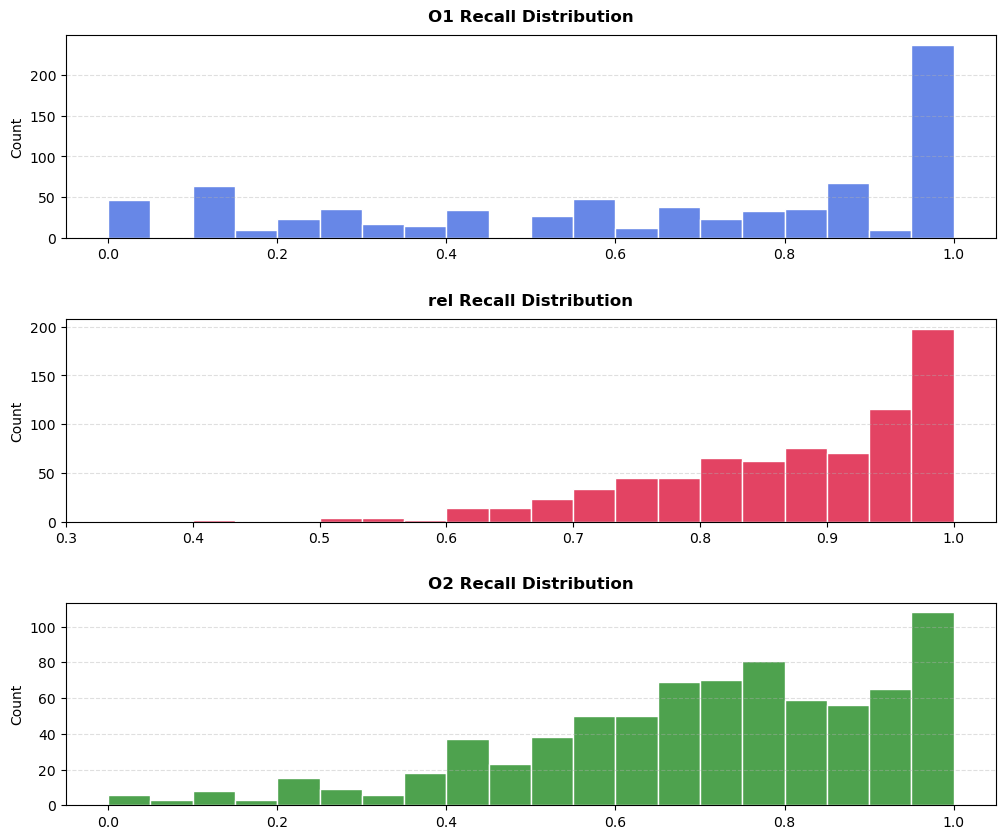

In [113]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), gridspec_kw={'hspace': 0.4})

# Plot 1
sns.histplot(o1_recalls, bins=20, ax=axes[0], color='royalblue', edgecolor='white', alpha=0.8)
axes[0].set_title('O1 Recall Distribution', fontweight='bold', pad=10)
axes[0].grid(axis='y', linestyle='--', alpha=0.4)

# Plot 2
sns.histplot(rel_recalls, bins=20, ax=axes[1], color='crimson', edgecolor='white', alpha=0.8)
axes[1].set_title('rel Recall Distribution', fontweight='bold', pad=10)
axes[1].grid(axis='y', linestyle='--', alpha=0.4)

# Plot 3
sns.histplot(o2_recalls, bins=20, ax=axes[2], color='forestgreen', edgecolor='white', alpha=0.8)
axes[2].set_title('O2 Recall Distribution', fontweight='bold', pad=10)
axes[2].grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()


In [114]:
o1_recalls.index[:10]


Index(['Sequence_T3_6587', 'Interaction_T3_4797', 'Sequence_T3_1261',
       'Sequence_T3_974', 'Interaction_T2_7397', 'Interaction_T1_4320',
       'Interaction_T2_127', 'Sequence_T3_2682', 'Sequence_T5_5995',
       'Feasibility_T5_553'],
      dtype='object')

In [115]:
bests = list(set(o1_recalls.index[:100]) & set(rel_recalls.index[:100]) & set(o2_recalls.index[:100]))
bests


['Sequence_T1_5300',
 'Interaction_T3_2407',
 'Interaction_T1_4166',
 'Sequence_T3_974',
 'Interaction_T1_3792',
 'Interaction_T2_5875']

In [116]:
test1 = bests[0]

print(f"Recall values for {test1}")
print(f"o1: {o1_recalls[test1]}")
print(f"rel: {rel_recalls[test1]}")
print(f"o2: {o2_recalls[test1]}")


Recall values for Sequence_T1_5300
o1: 1.0
rel: 1.0
o2: 1.0


In [117]:
frames = struct_gen_graphs[test_id]
frames.keys()


dict_keys(['000019', '000054', '000083', '000124', '000160', '000198', '000206', '000228', '000251'])

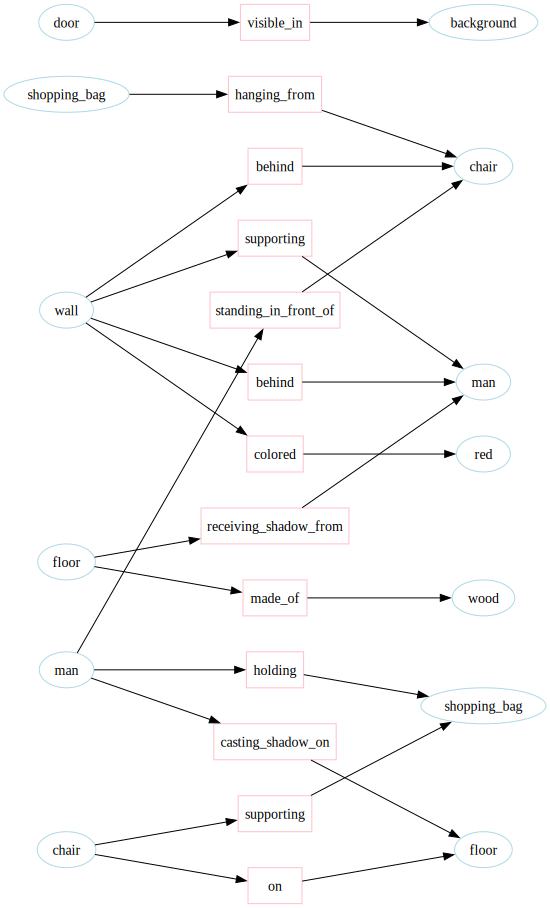

In [118]:
draw_tripartite_graph(struct_gen_graphs[test_id]['000019'])


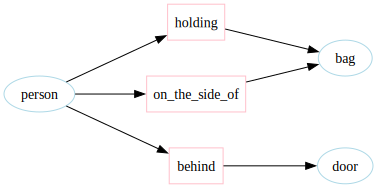

In [119]:
draw_tripartite_graph(STAR_data_df['stsg'][test_id]['000019'])


In [120]:
# TODO: viz actual frame

raw_video_dir = WORK_DIR / 'data/datasets/action-genome/Charades_v1_480/'
raw_frame_dir = WORK_DIR / 'data/datasets/action-genome/frames/'
annotation_dir = WORK_DIR / 'src/STAR_utils/annotations/STAR_classes/'
# pose_dir = root_dir + 'STAR/pose/'
# qa_train_dir = BASE_DIR /'data/datasets/STAR/STAR_annotations/STAR_train.json' 
qa_val_data = WORK_DIR / 'data/datasets/STAR/STAR_annotations/STAR_val.json' 
# qa_test_dir = BASE_DIR / 'data/datasets/STAR/STAR_annotations/STAR_test.json' 
save_video_dir = WORK_DIR / 'visualization_tmp'


In [123]:
import sys
sys.path.append(str(WORK_DIR / 'src'))
import STAR_utils.visualization_tools.vis_utils as vis_utils

vis_utils.frame_plot(['000019'], raw_frame_dir)


[ WARN:0@0.023] global loadsave.cpp:241 findDecoder imread_('/home/fabiolusha/Desktop/DeskArch-09-22/polimi/thesis/code/video-neurosymbolic/thesis/star_code/data/datasets/action-genome/frames/000019.png'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /croot/opencv-suite_1722029125240/work/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
